In [31]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from category_encoders import TargetEncoder
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

# Task 1 - BOW and Simple Features

In [32]:
# Read data and drop all non-US wines
wine_data_130 = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
wine_data_130 = wine_data_130[wine_data_130['country'] == 'US'] 

In [33]:
#drop everything below a 96% condidence interval, as the data is skewed to the right 
def remove_minor_outlier(df, columns):
    low = 0
    high = .96
    quant_df = df.quantile([low, high])
    for name in list(columns):
        df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

In [34]:
#limited predicting ability below 5 occurances 
def remove_cat_outlier(df, column):
    num_low_values = len([x for x in df[str(column)].dropna().value_counts() if x < 5])
    low_value_list = list(pd.Series(df[str(column)].dropna().value_counts()[-num_low_values:]).index)
    output = df[~df[column].isin(low_value_list)]
    return output
#add these later because what if this category appears in the test data??

## Visualize Data

Doing an initial data exploration to determine what confidence interval to use when removing outliers, and getting a feel for the data and different relationships to the points awarded.

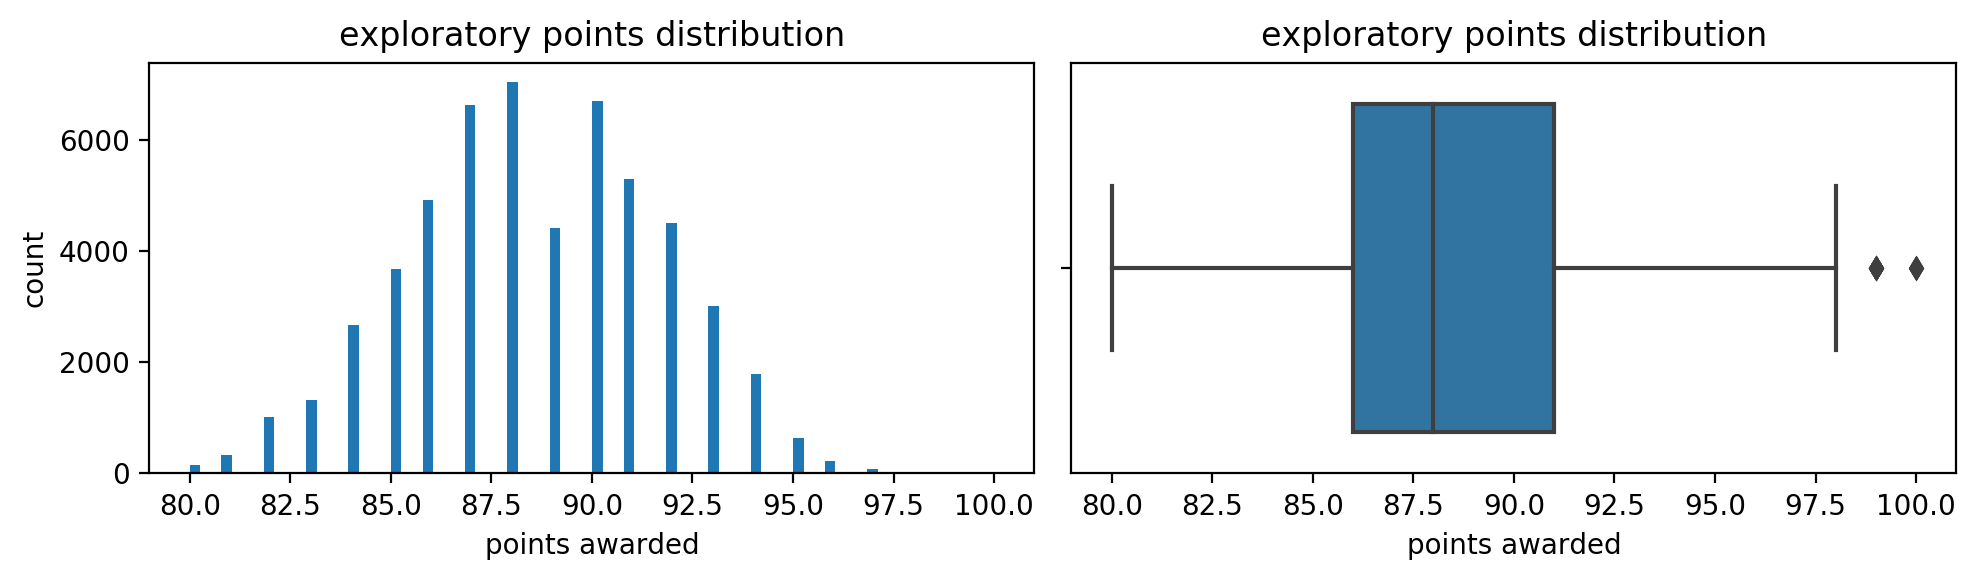

In [19]:
fig1, ax = plt.subplots(1,2, figsize=(10,3), dpi=200, sharex=True)
ax1, ax2 = ax.ravel()
ax1.hist(wine_data_130['points'],bins='auto')
ax1.set_title('exploratory points distribution')
ax1.set_xlabel('points awarded')
ax1.set_ylabel('count')


ax2 = sns.boxplot(wine_data_130['points'])
ax2.set_title('exploratory points distribution')
ax2.set_xlabel('points awarded')
fig1.tight_layout()

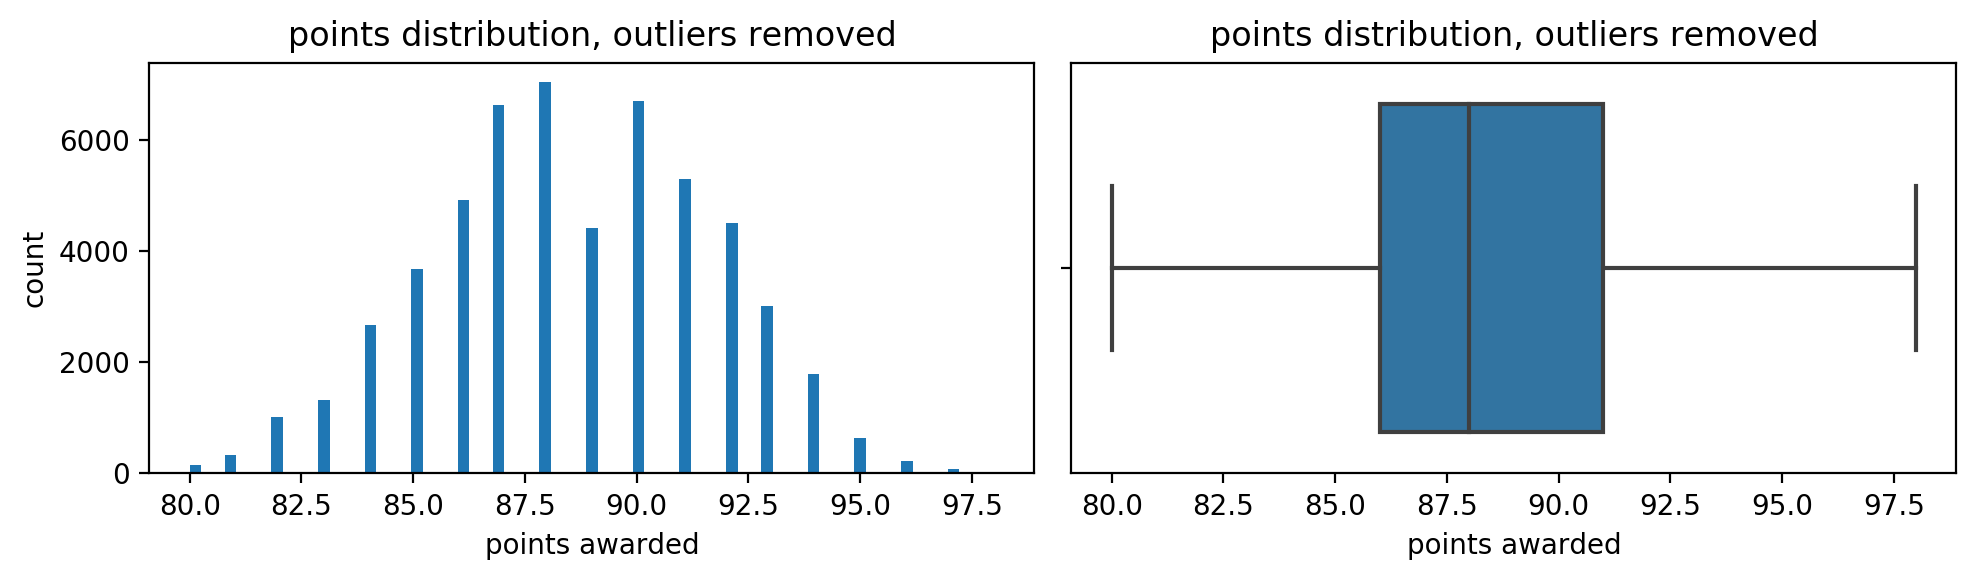

In [36]:
wine_data_130 = wine_data_130[wine_data_130['points'] <=98] #removing the outliers shown above

fig1, ax = plt.subplots(1,2, figsize=(10,3), dpi=200, sharex=True)
ax1, ax2 = ax.ravel()
ax1.hist(wine_data_130['points'],bins='auto')
ax1.set_title('points distribution, outliers removed')
ax1.set_xlabel('points awarded')
ax1.set_ylabel('count')


ax2 = sns.boxplot(wine_data_130['points'])
ax2.set_title('points distribution, outliers removed')
ax2.set_xlabel('points awarded')
fig1.tight_layout()

It seems that a majority of wines score 98 or below, so this will be the cutoff when removing outliers. 

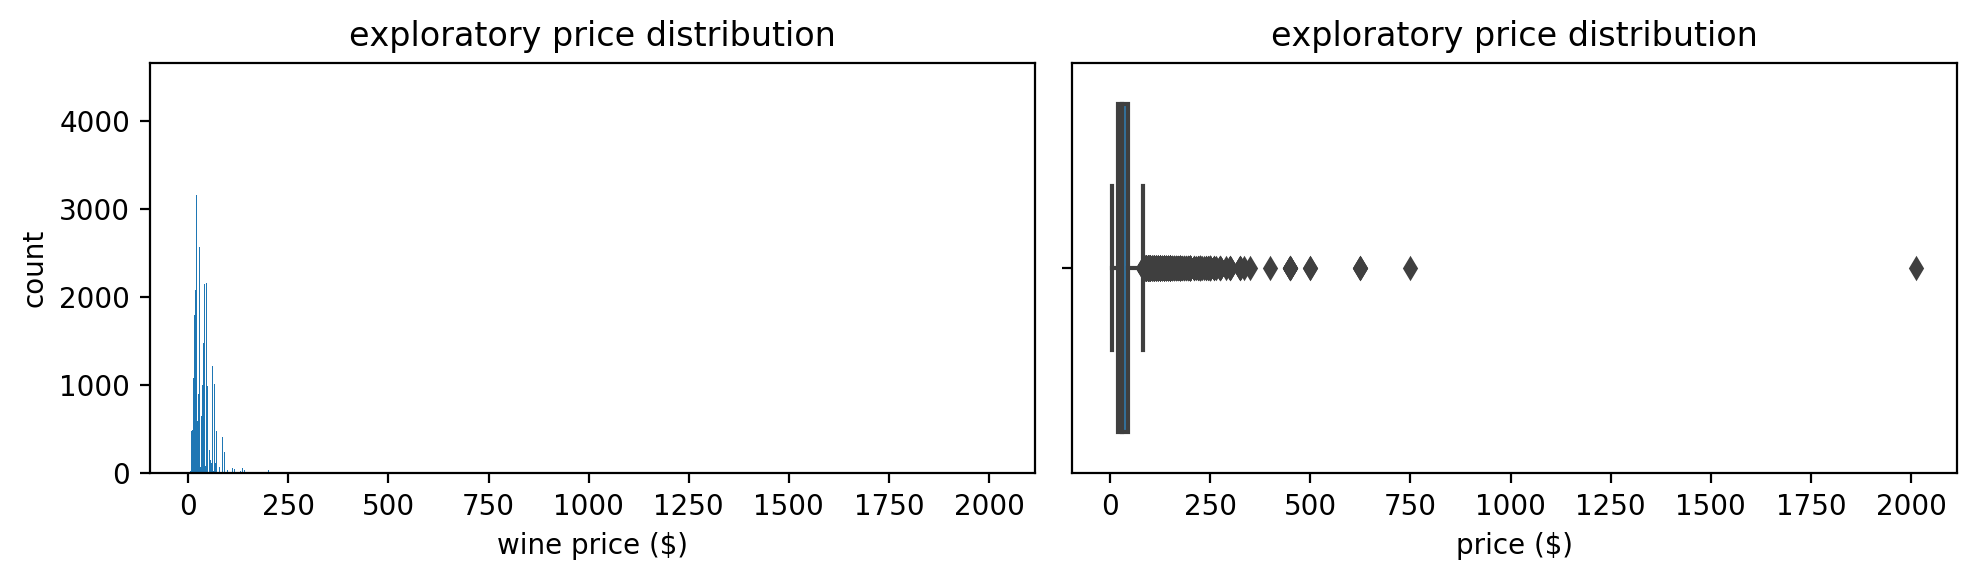

In [37]:
fig3, ax = plt.subplots(1,2, figsize=(10,3), dpi=200, sharex=True)
ax1, ax2 = ax.ravel()
ax1.hist(wine_data_130['price'].dropna(),bins='auto')
ax1.set_title('exploratory price distribution')
ax1.set_xlabel('wine price ($)')
ax1.set_ylabel('count')


ax2 = sns.boxplot(wine_data_130['price'].dropna())
ax2.set_title('exploratory price distribution')
ax2.set_xlabel('price ($)')
fig3.tight_layout()

it appears that soeone accidentally put '2013' (assuming the year, not $2,013.00) in the price category and it is skewing the results. This will be removed by taking the lower 95 percent of the data.We chose to not select a more aggressive cutoff even though there are still outliers below because some wines do cost hundreds of dollars, and we want to be able to account for them the same was a somm would (the purpose of the assignment) 

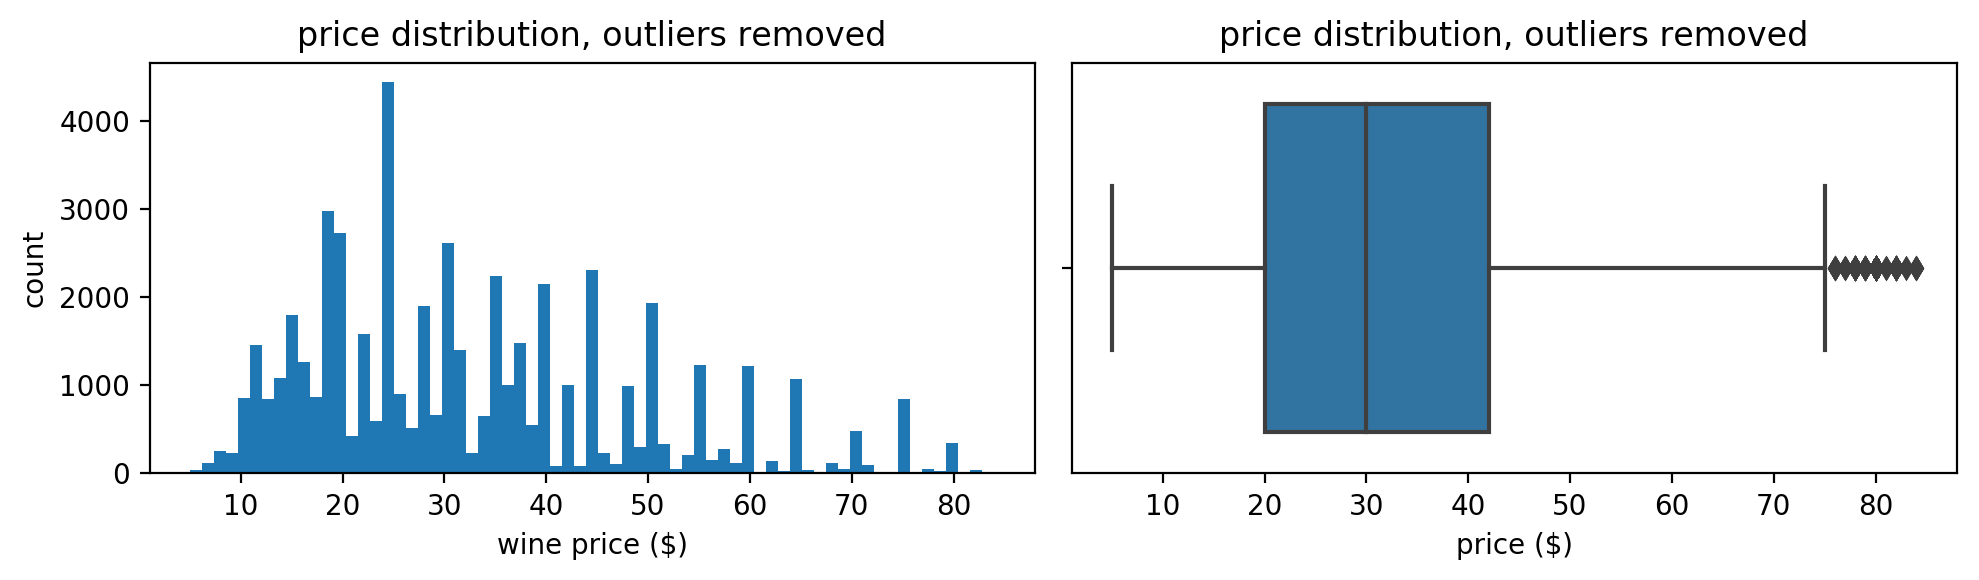

In [38]:
wine_data_130 = remove_minor_outlier(wine_data_130,['price']) #removing the top 1% of data 

fig4, ax = plt.subplots(1,2, figsize=(10,3), dpi=200, sharex=True)
ax1, ax2 = ax.ravel()
ax1.hist(wine_data_130['price'].dropna(),bins='auto',align='mid')
ax1.set_title('price distribution, outliers removed')
ax1.set_xlabel('wine price ($)')
ax1.set_ylabel('count')


ax2 = sns.boxplot(wine_data_130['price'].dropna())
ax2.set_title('price distribution, outliers removed')
ax2.set_xlabel('price ($)')
fig4.tight_layout()

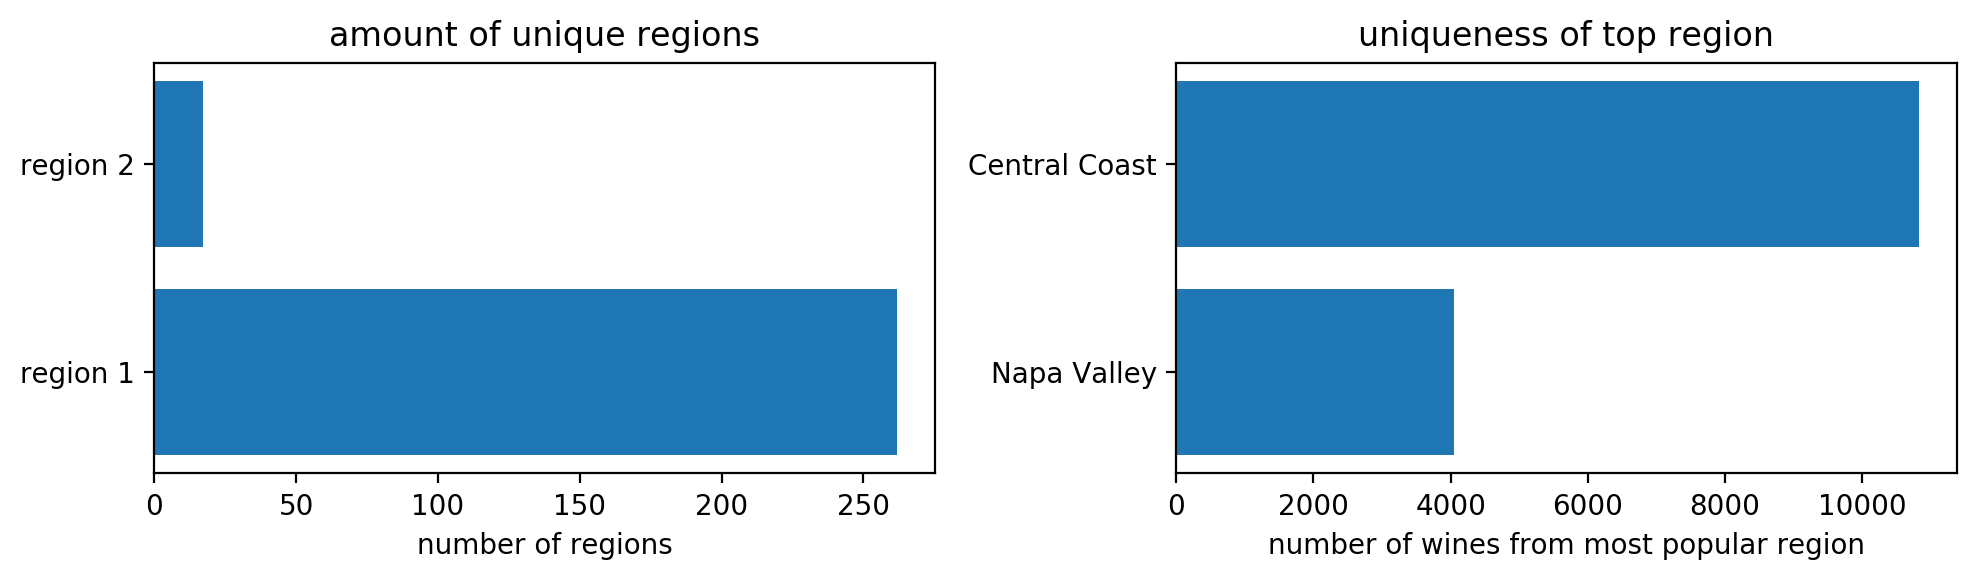

In [39]:
fig2, ax = plt.subplots(1,2, figsize=(10,3), dpi=200)
ax1, ax2 = ax.ravel()

ax1.barh(['region 1','region 2'],[wine_data_130['region_1'].dropna().describe()[1], wine_data_130['region_2'].dropna().describe()[1]])
ax1.set_title('amount of unique regions')
ax1.set_xlabel('number of regions')


ax2.barh(['Napa Valley','Central Coast'], [wine_data_130['region_1'].dropna().describe()[3], wine_data_130['region_2'].dropna().describe()[3]])
ax2.set_title('uniqueness of top region')
ax2.set_xlabel('number of wines from most popular region')

fig2.tight_layout()

It is clear from this data as well as the cells immediately below that 'region_1' contains many regions that are sparsely populated, with many only having 1-2 wines, and 'region_2' contains fewer regions (18) each with many wines. It appears that the first region is more specific, and the second region is more general. Because having n=1 is not helpful in predictions, we have decided to drop wine reviews with 'region_1' values that have less than 5 wines in it. Keeping both regions is still informative. 

In [10]:
wine_data_130['region_1'].dropna().describe()

count           53423
unique            263
top       Napa Valley
freq             4229
Name: region_1, dtype: object

In [11]:
wine_data_130['region_2'].dropna().describe()

count             49729
unique               17
top       Central Coast
freq              10956
Name: region_2, dtype: object

### Remove Outliers (according to observations) + Sample Data + Drop the 'taster_twitter_handle' column

In [40]:
#dropping categories that have less than 5 entries 
wine_data_130 = remove_cat_outlier(wine_data_130,'region_1')
wine_data_130 = remove_cat_outlier(wine_data_130,'province')
wine_data_130 = remove_cat_outlier(wine_data_130,'variety')
wine_data_130 = remove_cat_outlier(wine_data_130,'winery')
wine_data_130 = remove_cat_outlier(wine_data_130,'designation')

Also, drop the taster's twitter handle as it will be redudant with the taster's name

In [41]:
wine_data_130 = wine_data_130.drop(columns=['taster_twitter_handle'])

In [42]:
# taking half of the dataset for quicker run times
wine_data_130 = wine_data_130.sample(frac=0.5)

#### Splitting the data so that 'points' is the target as they are what is used to represent the wine quality. Additionally, 'Country' is no longer important becuase we have specified that only US wines be included. 

In [43]:
points = wine_data_130['points'] #target
X = wine_data_130.drop(columns=['country', 'points']) #redundant features
X.head() #visual overview for people that have not seen this dataset before. 

,description,designation,price,province,region_1,region_2,taster_name,title,variety,winery
92775,"This Cabernet Sauvingon, Syrah and Merlot domi...",Chalk Line,25.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,Guardian 2013 Chalk Line Red (Columbia Valley ...,Red Blend,Guardian
10894,"This could be considered a liquid dessert, wit...",NaN,14.0,California,California,California Other,Jim Gordon,Korbel NV Chardonnay (California),Chardonnay,Korbel
46035,"Just a small amount of this wine was made, ble...",NaN,42.0,California,Russian River Valley,Sonoma,Virginie Boone,Crux 2013 Petite Sirah (Russian River Valley),Petite Sirah,Crux
51895,A gorgeous Pinot Noir that shows winemaker Eri...,Rodgers Creek Vineyard,48.0,California,Sonoma Coast,Sonoma,NaN,Sojourn 2011 Rodgers Creek Vineyard Pinot Noir...,Pinot Noir,Sojourn
101663,"Although full-bodied and rich in texture, this...",NaN,36.0,California,Livermore Valley,Central Coast,Jim Gordon,Cuda Ridge Wines 2014 Cabernet Franc (Livermor...,Cabernet Franc,Cuda Ridge Wines


### Impute missing values (all except 'description' & 'title')

In [44]:
categorical = ['designation', 'province', 'region_1', 'region_2', 'variety', 'winery', 'taster_name']
continuous = ['price']
impute_categorical = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
impute_float = KNNImputer(missing_values=np.nan)

In [45]:
X[categorical] = impute_categorical.fit_transform(X[categorical])
X[continuous] = impute_float.fit_transform(X[continuous])

## Visualising the imputed data

note: categories that had over ~2,000 unique values were not graphed as they were uninformative.

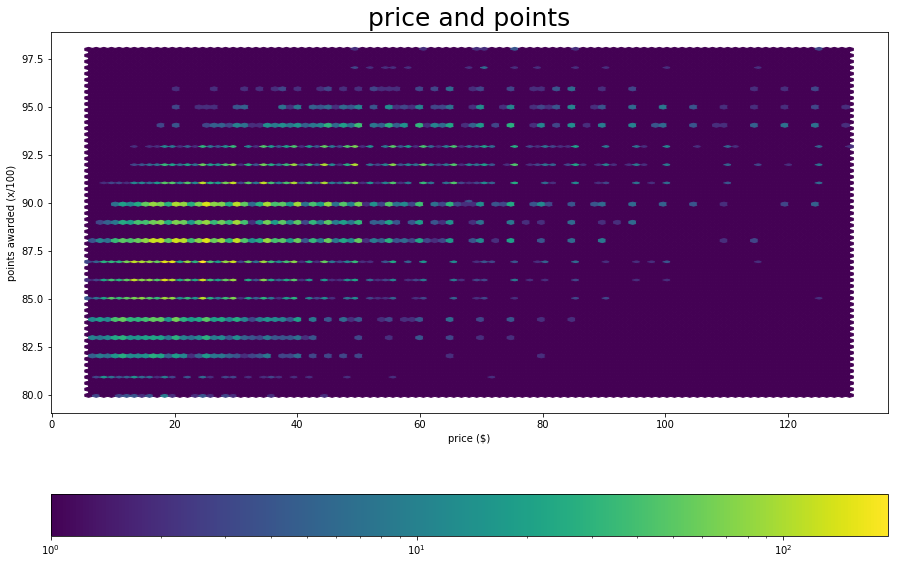

In [49]:
plt.figure(figsize=(15,10))
plt.hexbin(X['price'], points, bins='log')
plt.title('price and points', fontsize=25)
plt.xlabel('price ($)')
plt.ylabel('points awarded (x/100)')
plt.colorbar(orientation='horizontal')

There is a slight positive linear correlation between price and points, but this also shows that a majority of wines that were rated were in the lower 50% of prices. (good to know for wine shopping!)

In [50]:
def stripplot(category):
    plt.Figure()
    ax=plt.subplots(figsize=(15,6))
    ax = sns.stripplot(x= X[category], y=points)
    ax.set_xticklabels(X[category],rotation=45)
    ax.set_title(f'{category} vs price', fontsize=20)

In [51]:
def stripplot_noticks(category):
    plt.Figure()
    ax=plt.subplots(figsize=(15,6))
    ax = sns.stripplot(x= X[category], y=points)
    ax.set_xticklabels([],rotation=45)
    ax.set_title(f'{category} vs points', fontsize=20)

In [52]:
def box(category):
    plt.Figure(figsize=(15,6))
    sns.set(style='whitegrid')
    ax = sns.boxplot(x=X[str(category)],y=points, showfliers = False)
    ax.set_title(f'{category} vs points', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

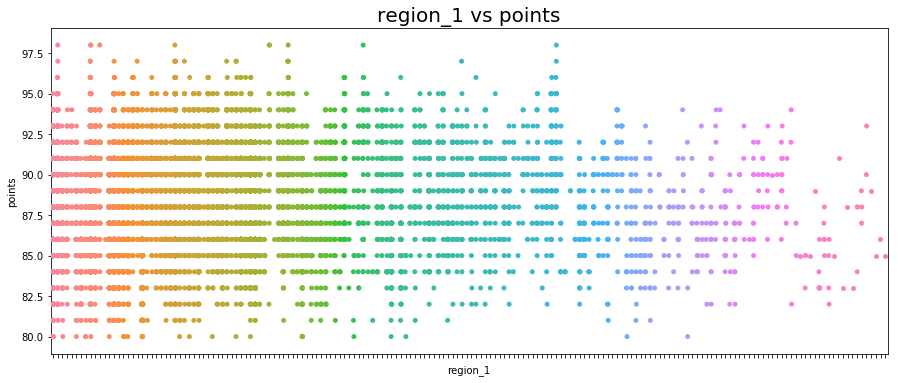

In [53]:
stripplot_noticks('region_1')

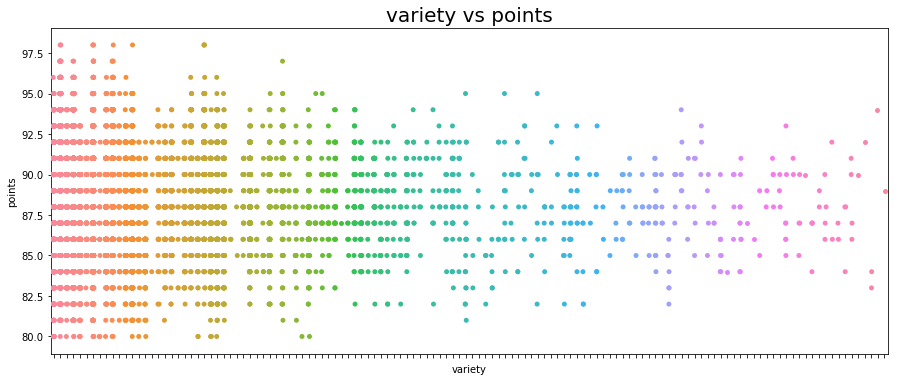

In [54]:
stripplot_noticks('variety')

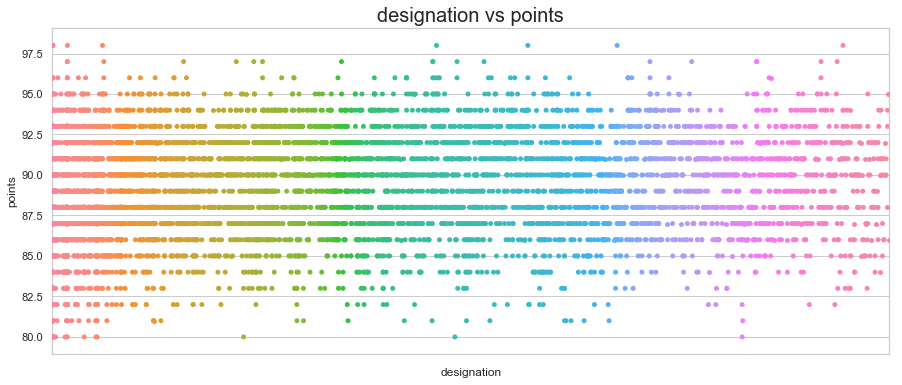

In [65]:
stripplot_noticks('designation')

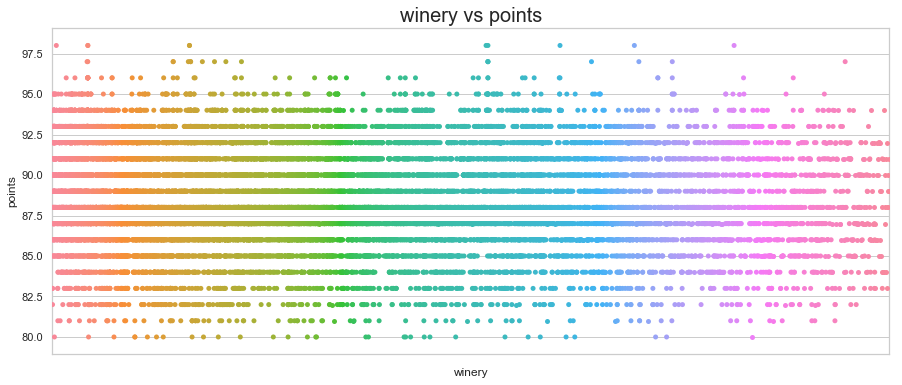

In [67]:
stripplot_noticks('winery')

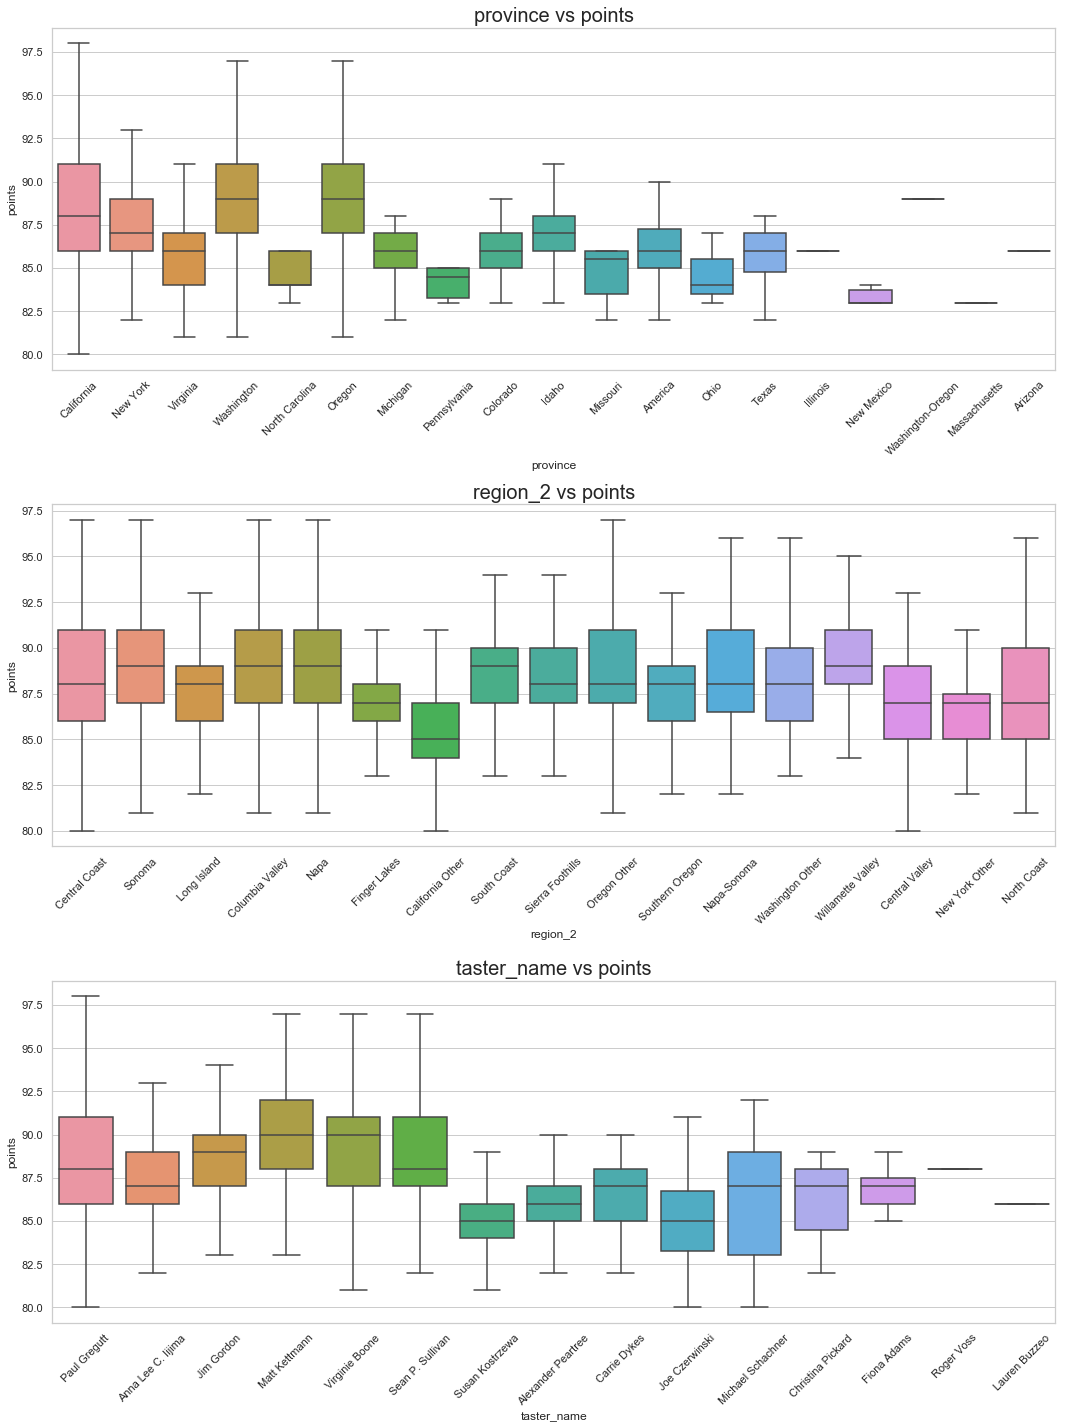

In [62]:
catfig = plt.figure(figsize=(15,20))
gs = catfig.add_gridspec(ncols=1,nrows=3)
i=0
for cat in ['province', 'region_2','taster_name']:
    ax = catfig.add_subplot(gs[i,0])
    i+=1
    box(cat)
catfig.tight_layout()

## 1.1 - Create a simpe baseline model with all non-text features

In [46]:
#after removing outliers
print('Number of different categories in each feature: ')
print(f'Province: {len(np.unique(X.province))}')
print(f'Designation: {len(np.unique(X.designation))}')
print(f'Region 1: {len(np.unique(X.region_1))}')
print(f'Region 2: {len(np.unique(X.region_2))}')
print(f'Variety: {len(np.unique(X.variety))}')
print(f'Winery: {len(np.unique(X.winery))}')
print(f'Taster: {len(np.unique(X.taster_name))}')

Number of different categories in each feature: 
Province: 18
Designation: 1084
Region 1: 177
Region 2: 17
Variety: 129
Winery: 2167
Taster: 15


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, points, shuffle=True, random_state=0)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=5)

In [113]:
# Remove the description column
X_train_no_text = X_train.drop(columns=['description', 'title'])

In [114]:
# Encode categorical features 
to_target_encode = ['designation', 'winery', 'variety', 'region_1', 'region_2']
to_ohe = ['province', 'taster_name']
to_scale = ['price']
# Create column transformer
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
ohe = make_pipeline(preprocessing.OneHotEncoder(handle_unknown='ignore'))
scale = make_pipeline(preprocessing.StandardScaler())
preprocessing_pipe = make_column_transformer((target_encoding, to_target_encode),
                                            (ohe, to_ohe),
                                            (scale, to_scale),
                                            remainder='passthrough')

### NOTE: We are working under an assumption based on the assignment question that this is to be done using all features EXCEPT for 'description' and 'title'

In [52]:
ridge_pipe = make_pipeline(preprocessing_pipe, Ridge())
param_grid = {'ridge__alpha': np.logspace(-3,3,10)}
ridge_grid = GridSearchCV(ridge_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train_no_text, y_train)
ridge_grid.best_score_

0.4167977474945765

In [53]:
lasso_pipe = make_pipeline(preprocessing_pipe, Lasso())
param_grid = {'lasso__alpha': np.logspace(-3,3,10)}
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train_no_text, y_train)
lasso_grid.best_score_

0.4160427170245691

### Conclusions: 
the models based on only non-text features were not very successful. 

## 1.2 - Create a simple text-based model using a bag-of-words approach and a linear model

### NOTE: We are working under the assumption that this is to be done using only the 'description' and 'title' feature as later on in the homework question we are tasked to combine text and non-text features

In [50]:
X_train_only_text = X_train.drop(columns=['designation', 'winery', 'variety', 'region_1', 'region_2', 'price', 'taster_name', 'province'])

In [51]:
token_vect = CountVectorizer(token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

In [52]:
# Grid search over CountVectorizer and Linear Model Parameters
param_grid_ridge = {
    'columntransformer__countvectorizer-1__min_df': (0, 1, 2, 3, 4),
    'columntransformer__countvectorizer-2__min_df': (0, 1, 2, 3, 4),
    'columntransformer__countvectorizer-1__max_features': (1000, 2500, 5000),
    'columntransformer__countvectorizer-2__max_features': (1000, 2500, 5000),
    'ridge__alpha': np.logspace(-3, 3, 10),
}
param_grid_lasso = {
    'columntransformer__countvectorizer-1__min_df': (0, 1, 2, 3, 4),
    'columntransformer__countvectorizer-2__min_df': (0, 1, 2, 3, 4),
    'columntransformer__countvectorizer-1__max_features': (1000, 2500, 5000),
    'columntransformer__countvectorizer-2__max_features': (1000, 2500, 5000),
    'lasso__alpha': np.logspace(-3, 3, 10),
}

In [53]:
vectorizer = make_column_transformer((token_vect, 'description'), 
                                     (token_vect, 'title'), 
                                     remainder='passthrough')

In [123]:
pipe = make_pipeline(vectorizer, Ridge())
ridge_grid = GridSearchCV(pipe, param_grid_ridge, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train_only_text, y_train)
ridge_grid.best_score_

0.714848585888834

In [145]:
pipe = make_pipeline(vectorizer, Lasso())
lasso_grid = GridSearchCV(pipe, param_grid_lasso, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train_only_text, y_train)
lasso_grid.best_score_

0.6876447418900412

# 1.2 (2) 
"Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets."

## Using Tfid Rescaling

In [54]:
#  **credit** author: @amueller, source: AML 2020 'working with text data', github: aml-19-text-data.ipynb
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

In [55]:
# Looking at TfidfVectorizer rescaling (same as CountVectorizer + TfidfTransformer in pipeline)
from sklearn.feature_extraction.text import TfidfVectorizer
tfid_vect = TfidfVectorizer(token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

In [56]:
param_grid_ridge = {
    'columntransformer__tfidfvectorizer-1__min_df': (1, 2, 3, 4),
    'columntransformer__tfidfvectorizer-2__min_df': (1, 2, 3, 4),
    'columntransformer__tfidfvectorizer-1__max_features': (1000, 2500, 5000),
    'columntransformer__tfidfvectorizer-2__max_features': (1000, 2500, 5000),
    'ridge__alpha': np.logspace(-3, 3, 10),
}
param_grid_lasso = {
    'columntransformer__tfidfvectorizer-1__min_df': (0, 1, 2, 3, 4),
    'columntransformer__tfidfvectorizer-2__min_df': (0, 1, 2, 3, 4),
    'columntransformer__tfidfvectorizer-1__max_features': (1000, 2500, 5000),
    'columntransformer__tfidfvectorizer-2__max_features': (1000, 2500, 5000),
    'lasso__alpha': np.logspace(-3, 3, 10),
}

In [57]:
vectorizer = make_column_transformer((tfid_vect, 'description'), 
                                     (tfid_vect, 'title'), 
                                     remainder='passthrough')

In [158]:
pipe = make_pipeline(vectorizer, Ridge())
ridge_grid = GridSearchCV(pipe, param_grid_ridge, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train_only_text, y_train)
print(f'best score: {ridge_grid.best_score_} best params: {ridge_grid.best_params_}')

best score: 0.6963994614030082 best params: {'columntransformer__tfidfvectorizer-1__max_features': 2500, 'columntransformer__tfidfvectorizer-1__min_df': 4, 'columntransformer__tfidfvectorizer-2__max_features': 5000, 'columntransformer__tfidfvectorizer-2__min_df': 1, 'ridge__alpha': 2.154434690031882}


In [156]:
pipe = make_pipeline(vectorizer, Lasso())
lasso_grid = GridSearchCV(pipe, param_grid_lasso, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train_only_text, y_train)
print(f'best score: {lasso_grid.best_score_} best params: {lasso_grid.best_params_}')

best score: 0.6063609767844074 best params: {'columntransformer__tfidfvectorizer-1__max_features': 1000, 'columntransformer__tfidfvectorizer-1__min_df': 2, 'columntransformer__tfidfvectorizer-2__max_features': 1000, 'columntransformer__tfidfvectorizer-2__min_df': 2, 'lasso__alpha': 0.001}


### Rationale comparing the 2 vectorizers:
Both Ridge and Lasso performed much worse with TfidVectorizer() than with CountVectorizer(). the main difference between the two is that TfidVectorizer rescales so that longer text entries do not hold more weight. There are multiple ways to rationalize this, but in this situation perhaps this is not advantageous. This may be because a 'just ok' wine may not inspire a lengthy review, but a truly fantastic or terrible wine will inspire a longer and more involved review, so those key words are weighted higher. This is not the bottom line, but helpful when thinking abbout it! 

## Using N-grams

In [74]:
ngram_param_grid = {
    'columntransformer__tfidfvectorizer-1__ngram_range': ((1,1),(1,2),(2,2),(1,3),(2,3)),
    'columntransformer__tfidfvectorizer-2__ngram_range': ((1,1),(1,2),(2,2),(1,3),(2,3)),
}
ngram_param_grid_count = {
    'columntransformer__countvectorizer-1__ngram_range': ((1,1),(1,2),(2,2),(1,3),(2,3)),
    'columntransformer__countvectorizer-2__ngram_range': ((1,1),(1,2),(2,2),(1,3),(2,3)),
}


In [75]:
tfid_vect_lasso = CountVectorizer(
                             max_features = 1000,
                             min_df = 2,
                             token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

ridge_description_tfid_vect = TfidfVectorizer(
                             max_features = 2500,
                             min_df = 4,
                             token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

ridge_title_tfid_vect = TfidfVectorizer(
                             max_features = 5000,
                             min_df = 1,
                             token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')


In [76]:
lasso_vectorizer = make_column_transformer((tfid_vect_lasso, 'description'), 
                                     (tfid_vect_lasso, 'title'), 
                                     remainder='passthrough')
ridge_vectorizer = make_column_transformer((ridge_description_tfid_vect, 'description'), 
                                     (ridge_title_tfid_vect, 'title'), 
                                     remainder='passthrough')

In [61]:
ridge_ngram_pipe = make_pipeline(ridge_vectorizer, Ridge(alpha=2.154434690031882))
ngram_ridge_grid = GridSearchCV(ridge_ngram_pipe, ngram_param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ngram_ridge_grid.fit(X_train_only_text, y_train)
print(f'best score: {ngram_ridge_grid.best_score_} best params: {ngram_ridge_grid.best_params_}')

best score: 0.7006052949753645 best params: {'columntransformer__tfidfvectorizer-1__ngram_range': (1, 1), 'columntransformer__tfidfvectorizer-2__ngram_range': (1, 1)}


In [77]:
lasso_ngram_pipe = make_pipeline(lasso_vectorizer, Lasso(alpha=0.001))
ngram_lasso_grid = GridSearchCV(lasso_ngram_pipe, ngram_param_grid_count, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ngram_lasso_grid.fit(X_train_only_text, y_train)
print(f'best score: {ngram_lasso_grid.best_score_} best params: {ngram_lasso_grid.best_params_}')

best score: 0.6702635136439006 best params: {'columntransformer__countvectorizer-1__ngram_range': (1, 1), 'columntransformer__countvectorizer-2__ngram_range': (1, 1)}


### Below are different performances of the 150k dataset with various lengths of n-grams to show the difference in the phrases from reviews

This can be helpful when understandign exactly what is happening behind the curtain, and is also helpful when looking up wine reviews on your own! 

In [99]:
#USING THE 150K DATASET
pipe = make_pipeline(ridge_bigram_vect, Ridge())
ridge_grid = GridSearchCV(pipe, param_grid_ridge, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train['description'], y_train)
print(f'best score: {ridge_grid.best_score_} best params: {ridge_grid.best_params_}')

best score: 0.7213533308551474 best params: {'ridge__alpha': 0.46415888336127775, 'tfidfvectorizer__ngram_range': (1, 2)}


In [79]:
#n-gram range = (2,2) 
pipe = make_pipeline(ridge_bigram_vect, Ridge())
ridge_grid = GridSearchCV(pipe, param_grid_ridge, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train['description'], y_train)
print(f'best score: {ridge_grid.best_score_} best params: {ridge_grid.best_params_}')

best score: 0.3453420657347337 best param: {'alpha': 10.0}


In [101]:
pipe = make_pipeline(lasso_bigram_vect, Lasso())
lasso_grid = GridSearchCV(pipe, param_grid_lasso, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train['description'], y_train)
print(f'best score: {lasso_grid.best_score_} best params: {lasso_grid.best_params_}')

best score: 0.6614902800785832 best params: {'countvectorizer__ngram_range': (1, 2), 'lasso__alpha': 0.001}


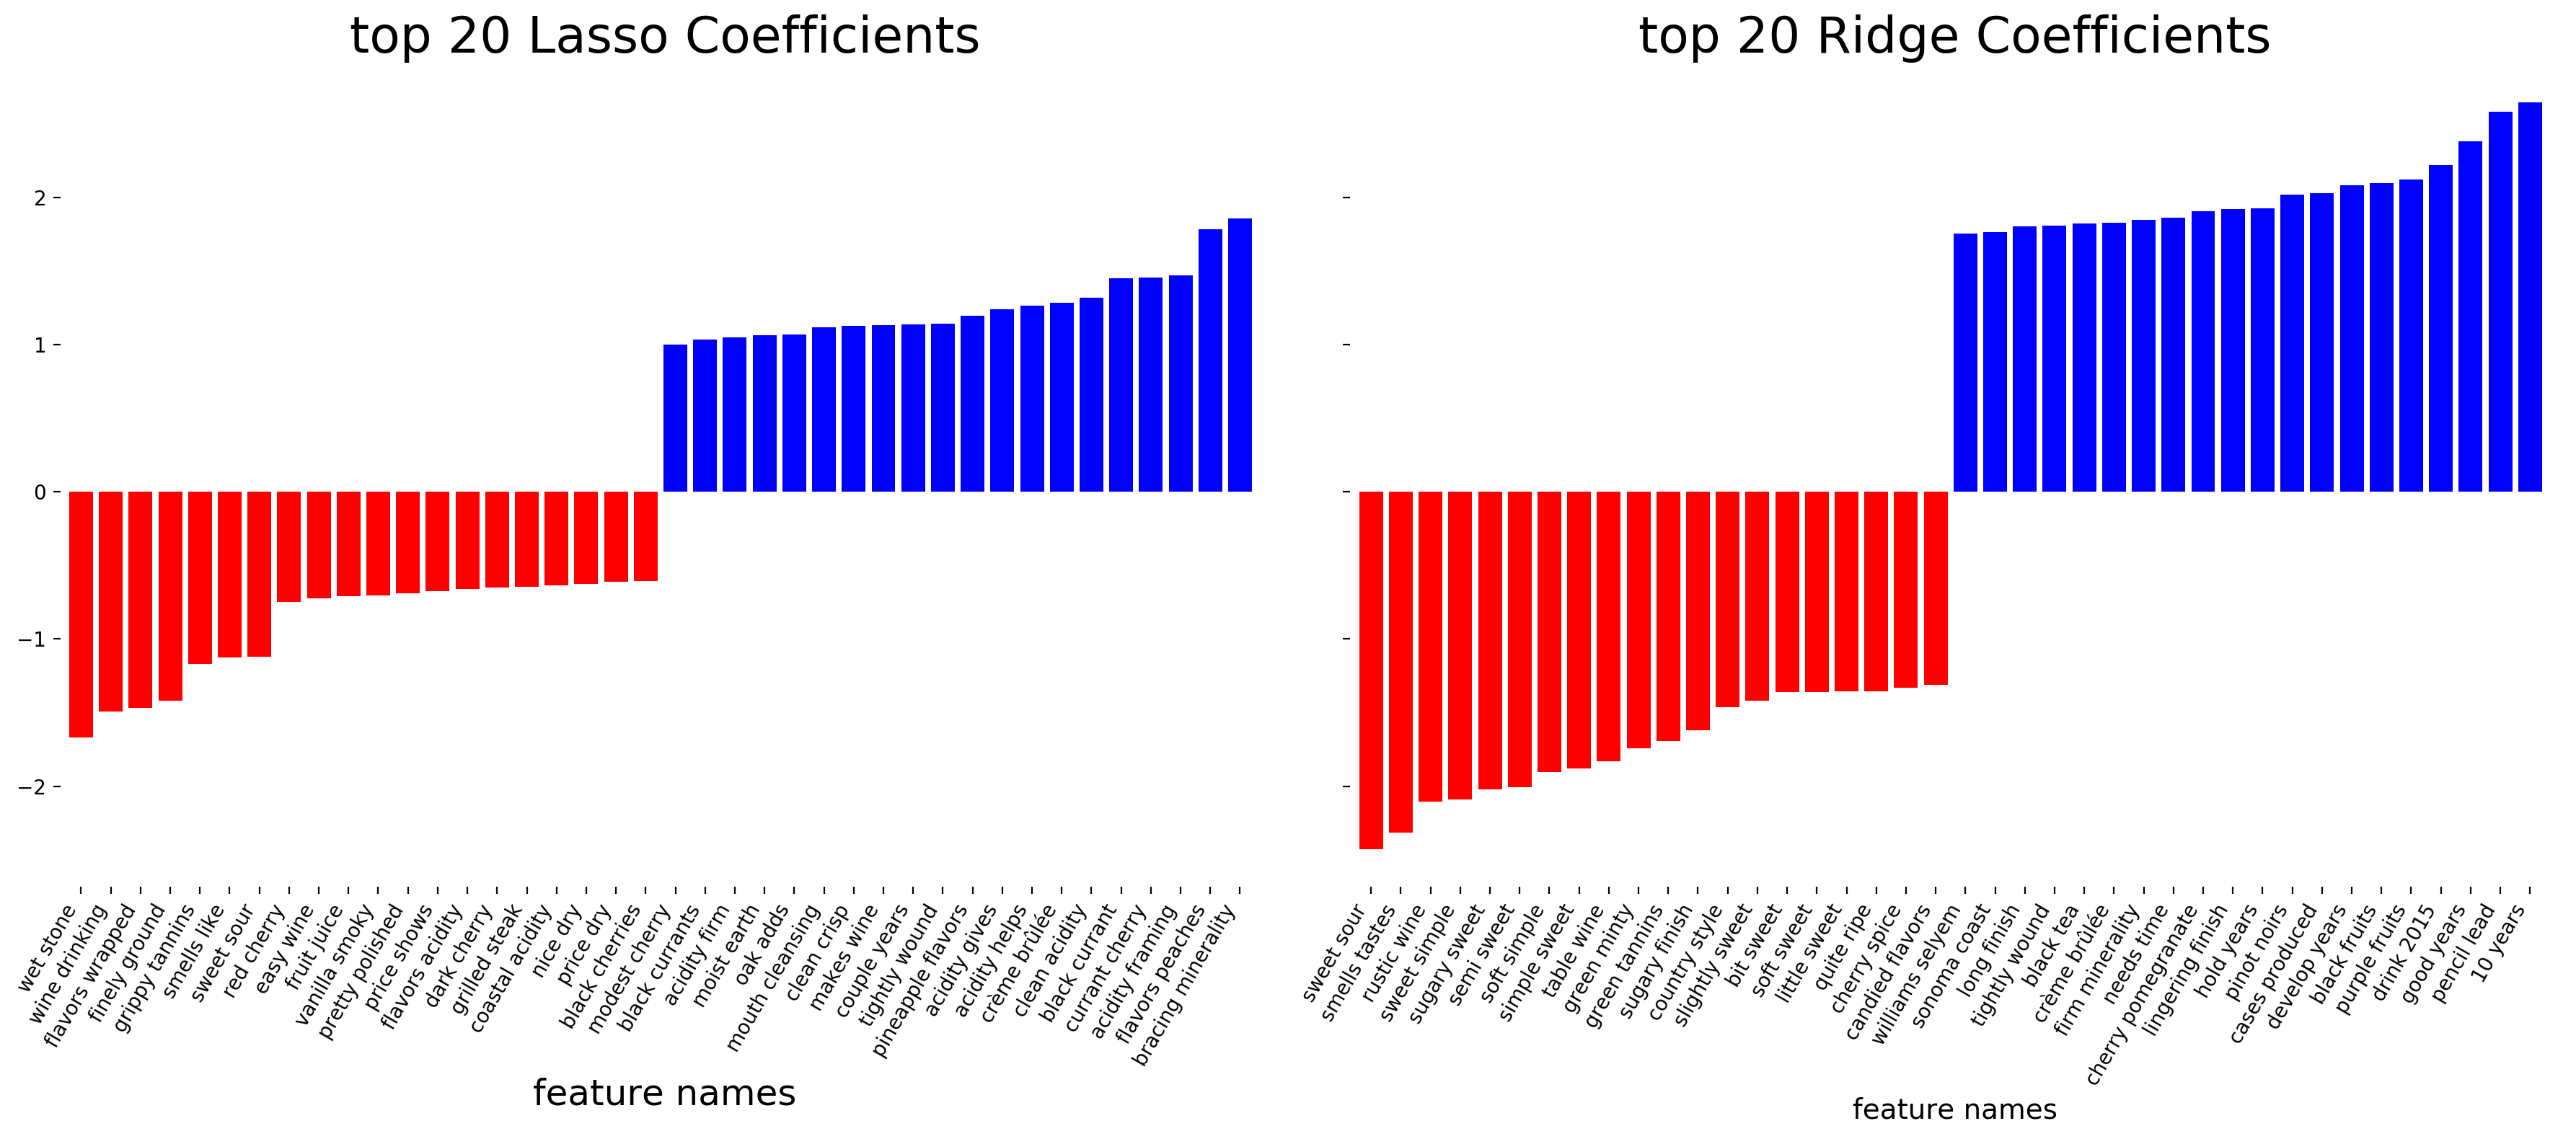

In [85]:
#Graph for bigrams range (2,2)

fig5, ax = plt.subplots(1,2, figsize=(18,8), dpi=200, sharey=True)
ax1, ax2 = ax.ravel()

plot_important_features(lasso_grid.best_estimator_.coef_,np.array(bigram_vect.get_feature_names()),ax=ax1)
ax1.set_title('top 20 Lasso Coefficients',fontsize=25)
ax1.set_xlabel('feature names',fontsize=18)


plot_important_features(ridge_grid.best_estimator_.coef_,np.array(bigram_vect.get_feature_names()),ax=ax2)
ax2.set_title('top 20 Ridge Coefficients',fontsize=25)
ax2.set_xlabel('feature names',fontsize=14)

fig5.tight_layout()

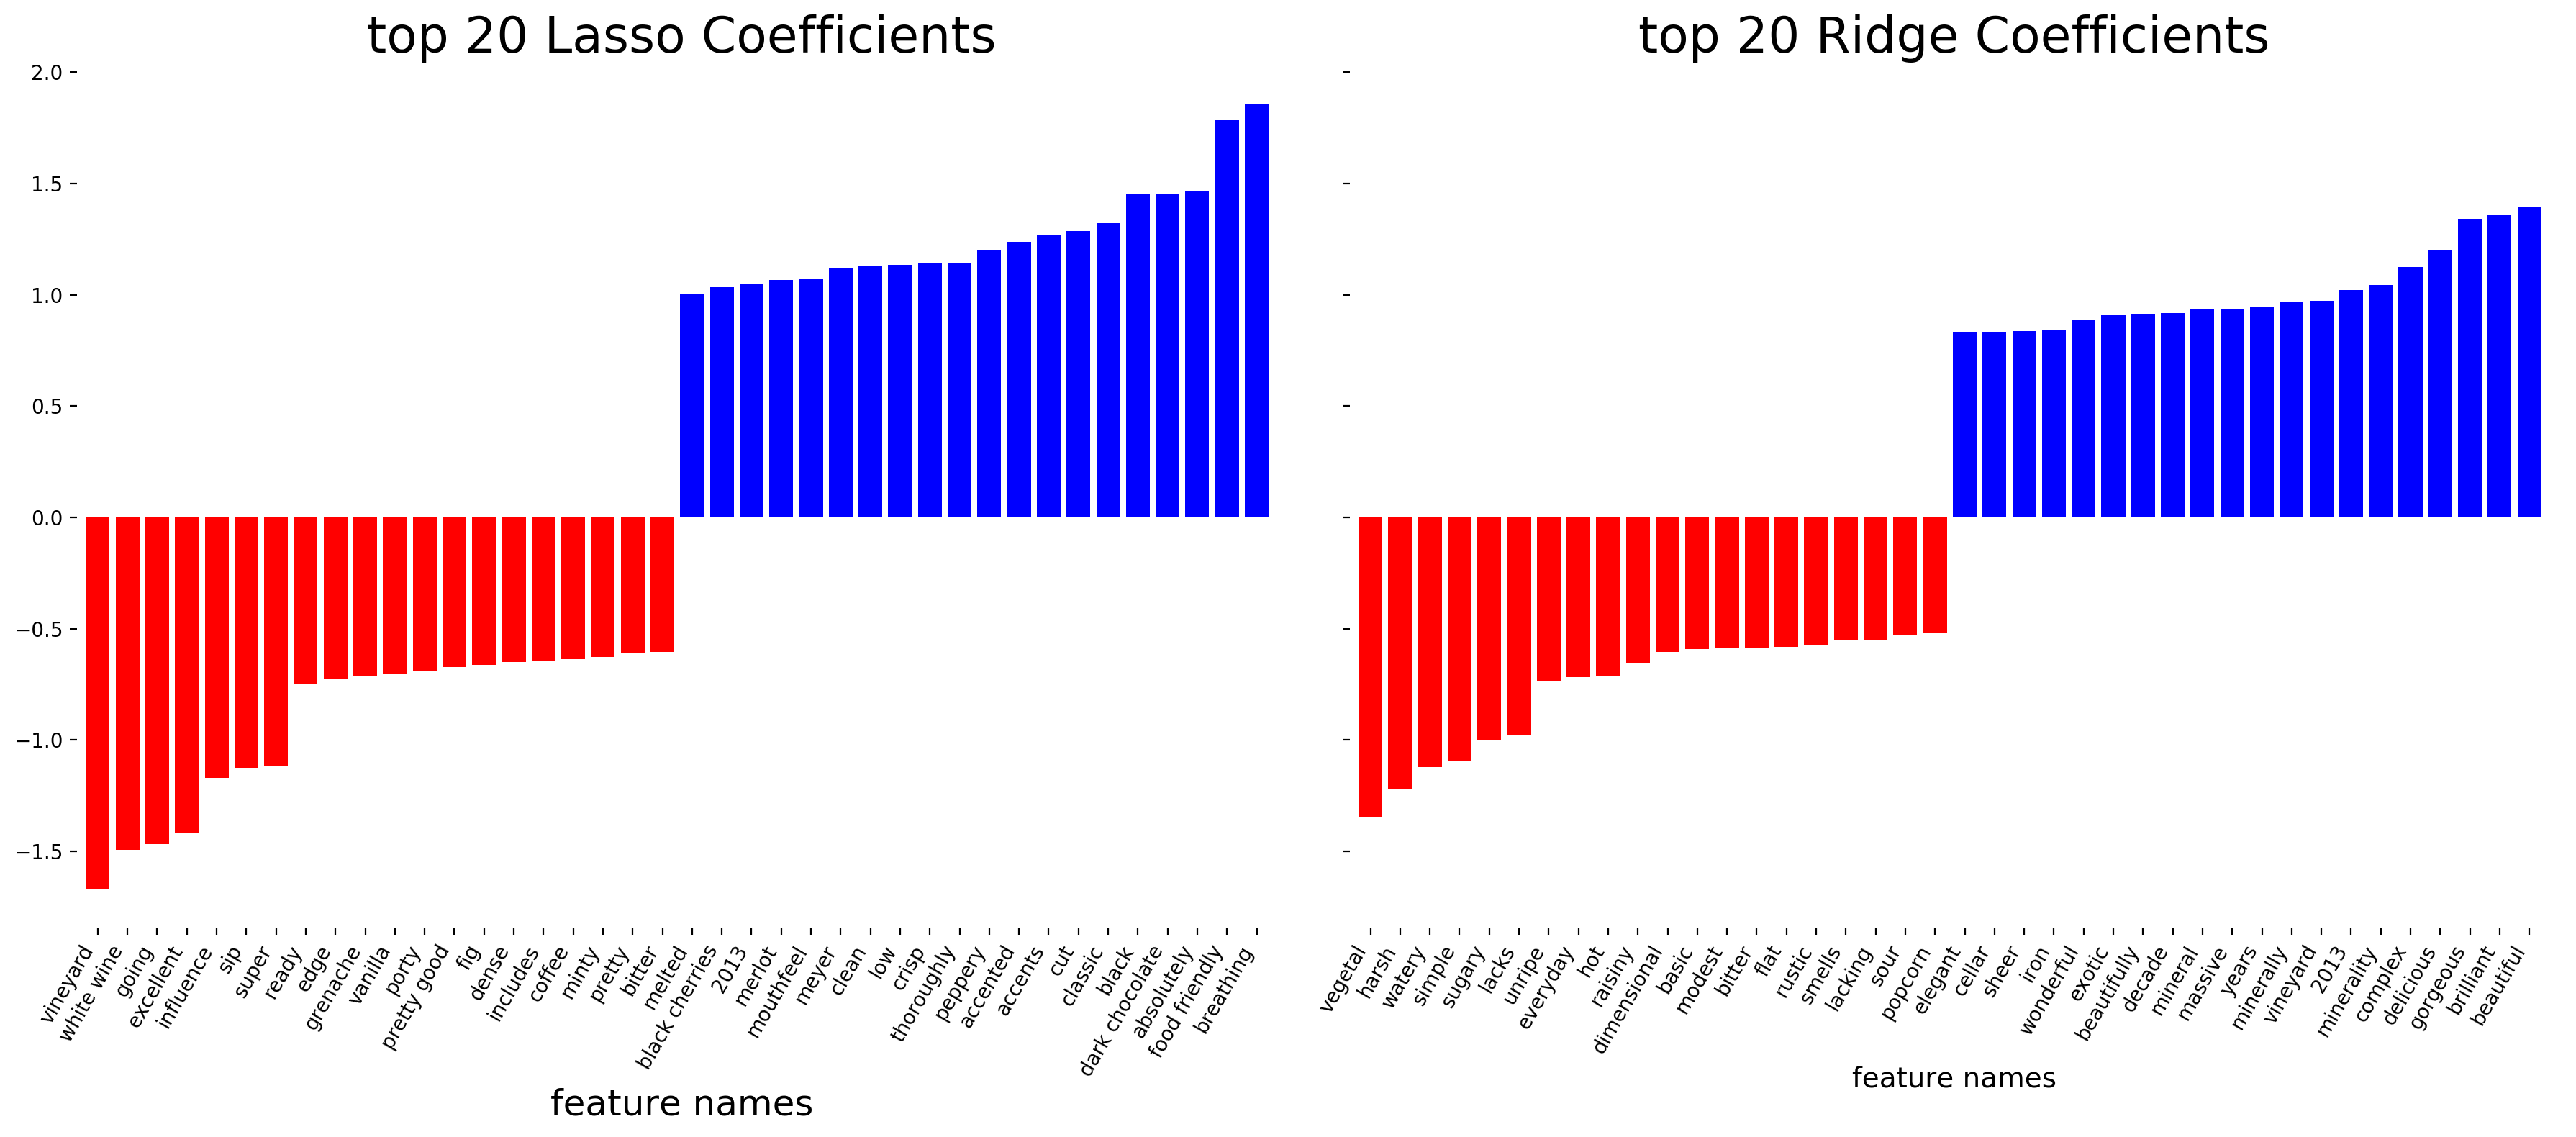

In [90]:
#graph for n-gram range (1,2)
fig5, ax = plt.subplots(1,2, figsize=(18,8), dpi=200, sharey=True)
ax1, ax2 = ax.ravel()

plot_important_features(lasso_grid.best_estimator_.coef_,np.array(bigram_vect.get_feature_names()),ax=ax1)
ax1.set_title('top 20 Lasso Coefficients',fontsize=25)
ax1.set_xlabel('feature names',fontsize=18)


plot_important_features(ridge_grid.best_estimator_.coef_,np.array(bigram_vect.get_feature_names()),ax=ax2)
ax2.set_title('top 20 Ridge Coefficients',fontsize=25)
ax2.set_xlabel('feature names',fontsize=14)

fig5.tight_layout()

In [20]:
#Tri-Grams (n-grams of (1,3) and (3,3))
trigram_vect=CountVectorizer(ngram_range=(3,3),
                            token_pattern=r"\b\w[\w’]+\b",
                            lowercase=True,
                            stop_words='english',
                            min_df=4,
                            max_features=1000)
desc_trigram_tokenized = trigram_vect.fit_transform(X_train['description'])

In [92]:
param_grid = {'alpha': np.logspace(-3,3,10)}
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(desc_trigram_tokenized, y_train)
print(f'best score: {ridge_grid.best_score_} best param: {ridge_grid.best_params_}')

best score: 0.12636419621823067 best param: {'alpha': 2.154434690031882}


In [93]:
param_grid = {'alpha': np.logspace(-3,3,10)}
lasso_grid = GridSearchCV(Lasso(), param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(desc_trigram_tokenized, y_train)
print(f'best score: {lasso_grid.best_score_} best param: {lasso_grid.best_params_}')

best score: 0.10481114823521631 best param: {'alpha': 0.001}


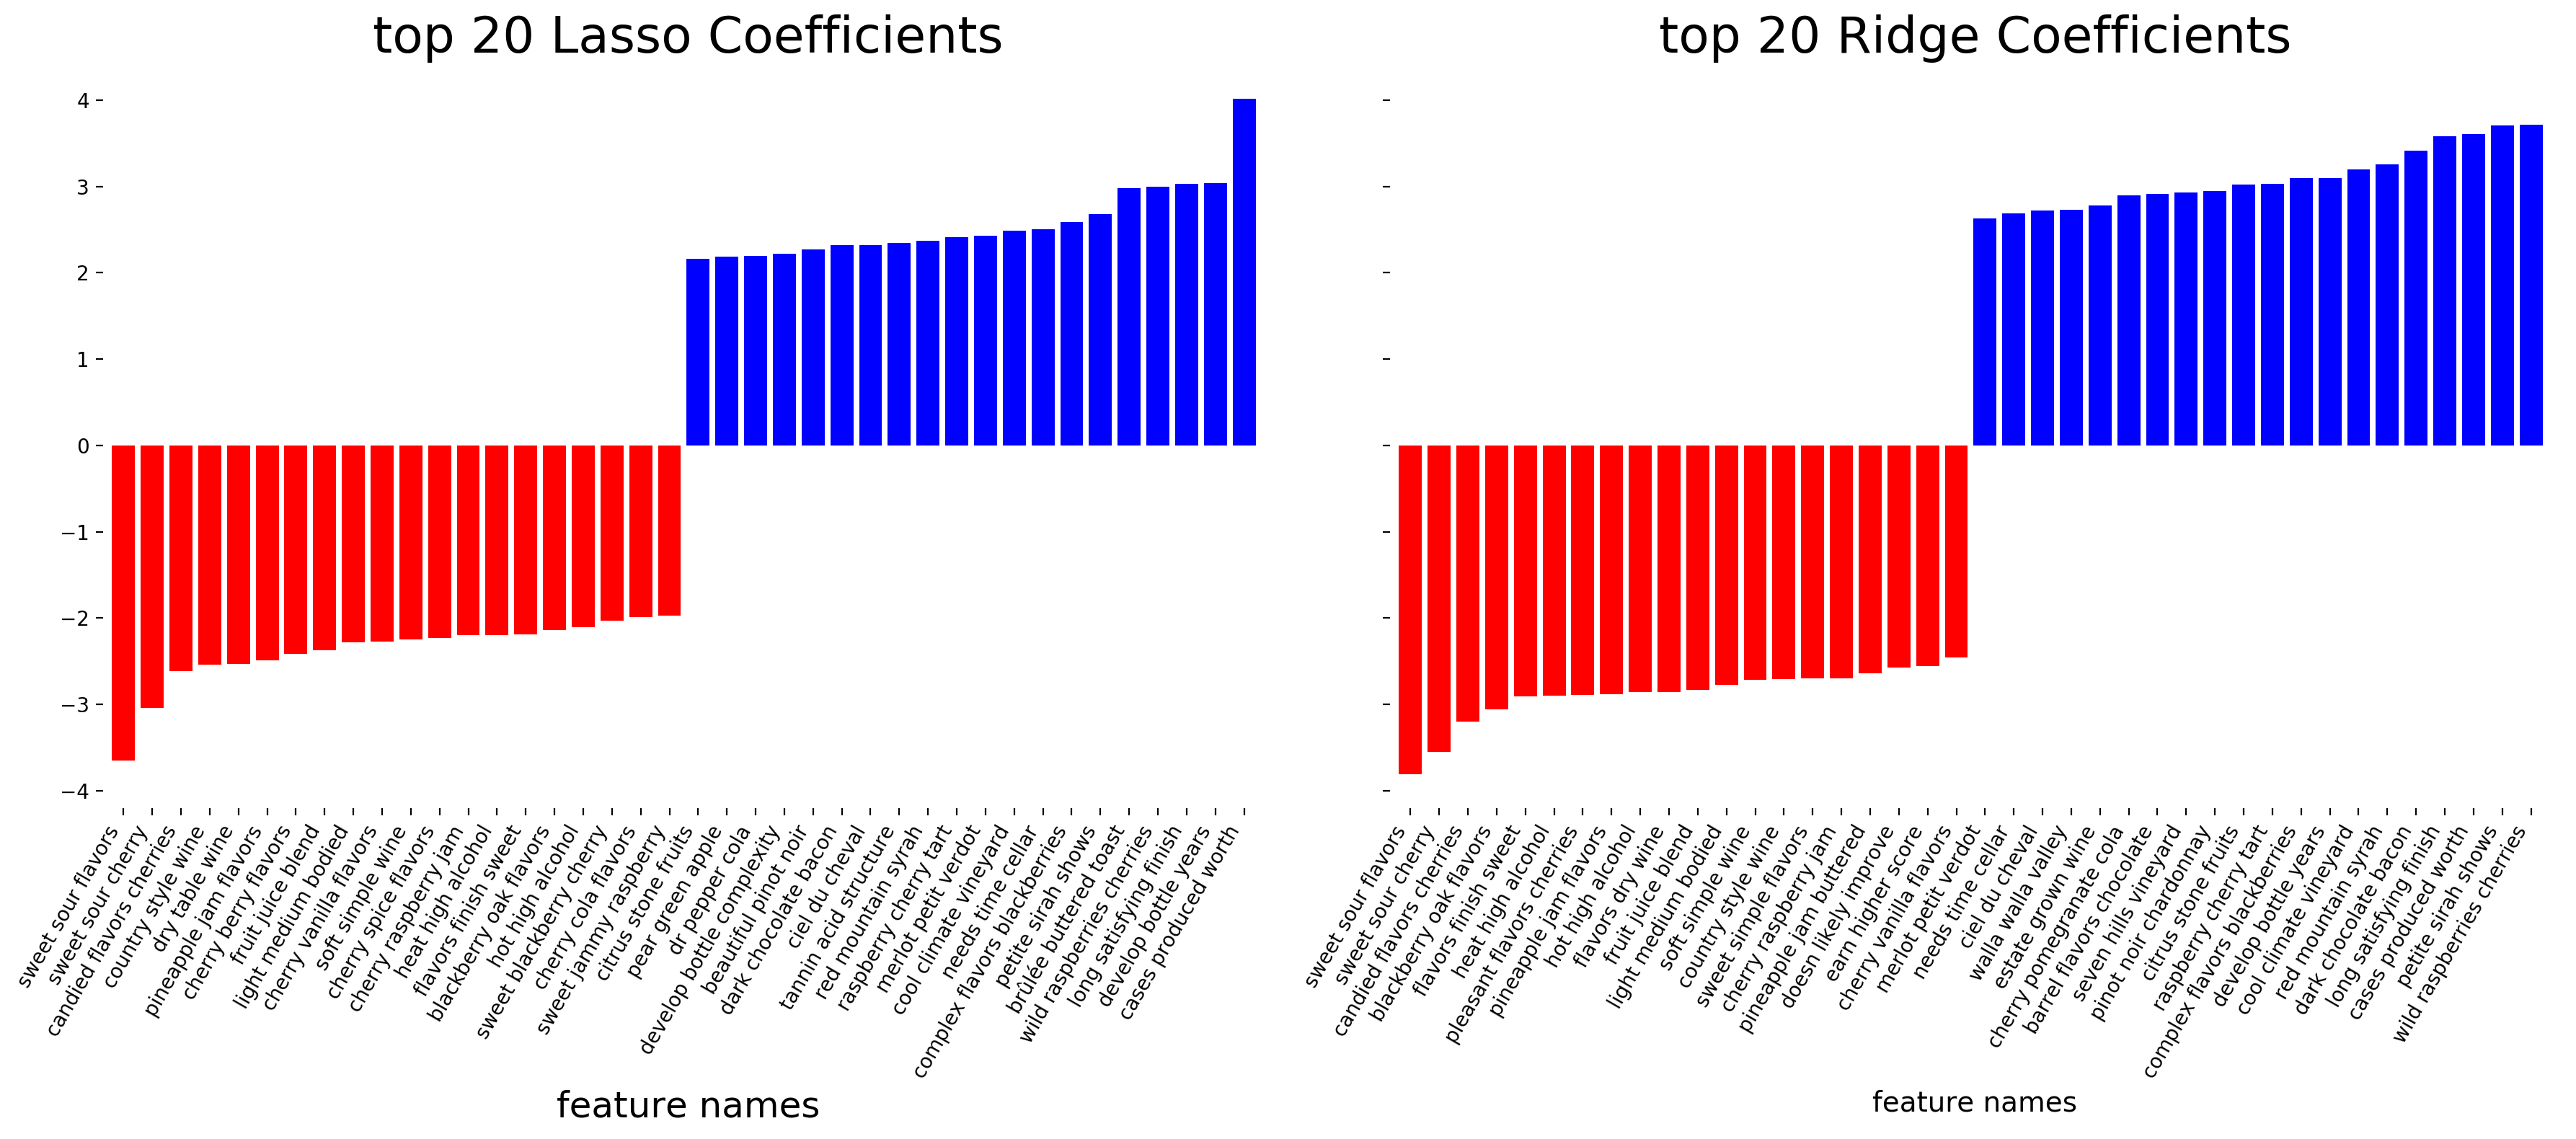

In [94]:
#graph for n-gram range (3,3)
fig6, ax = plt.subplots(1,2, figsize=(18,8), dpi=200, sharey=True)
ax1, ax2 = ax.ravel()

plot_important_features(lasso_grid.best_estimator_.coef_,np.array(trigram_vect.get_feature_names()),ax=ax1)
ax1.set_title('top 20 Lasso Coefficients',fontsize=25)
ax1.set_xlabel('feature names',fontsize=18)


plot_important_features(ridge_grid.best_estimator_.coef_,np.array(trigram_vect.get_feature_names()),ax=ax2)
ax2.set_title('top 20 Ridge Coefficients',fontsize=25)
ax2.set_xlabel('feature names',fontsize=14)

fig6.tight_layout()

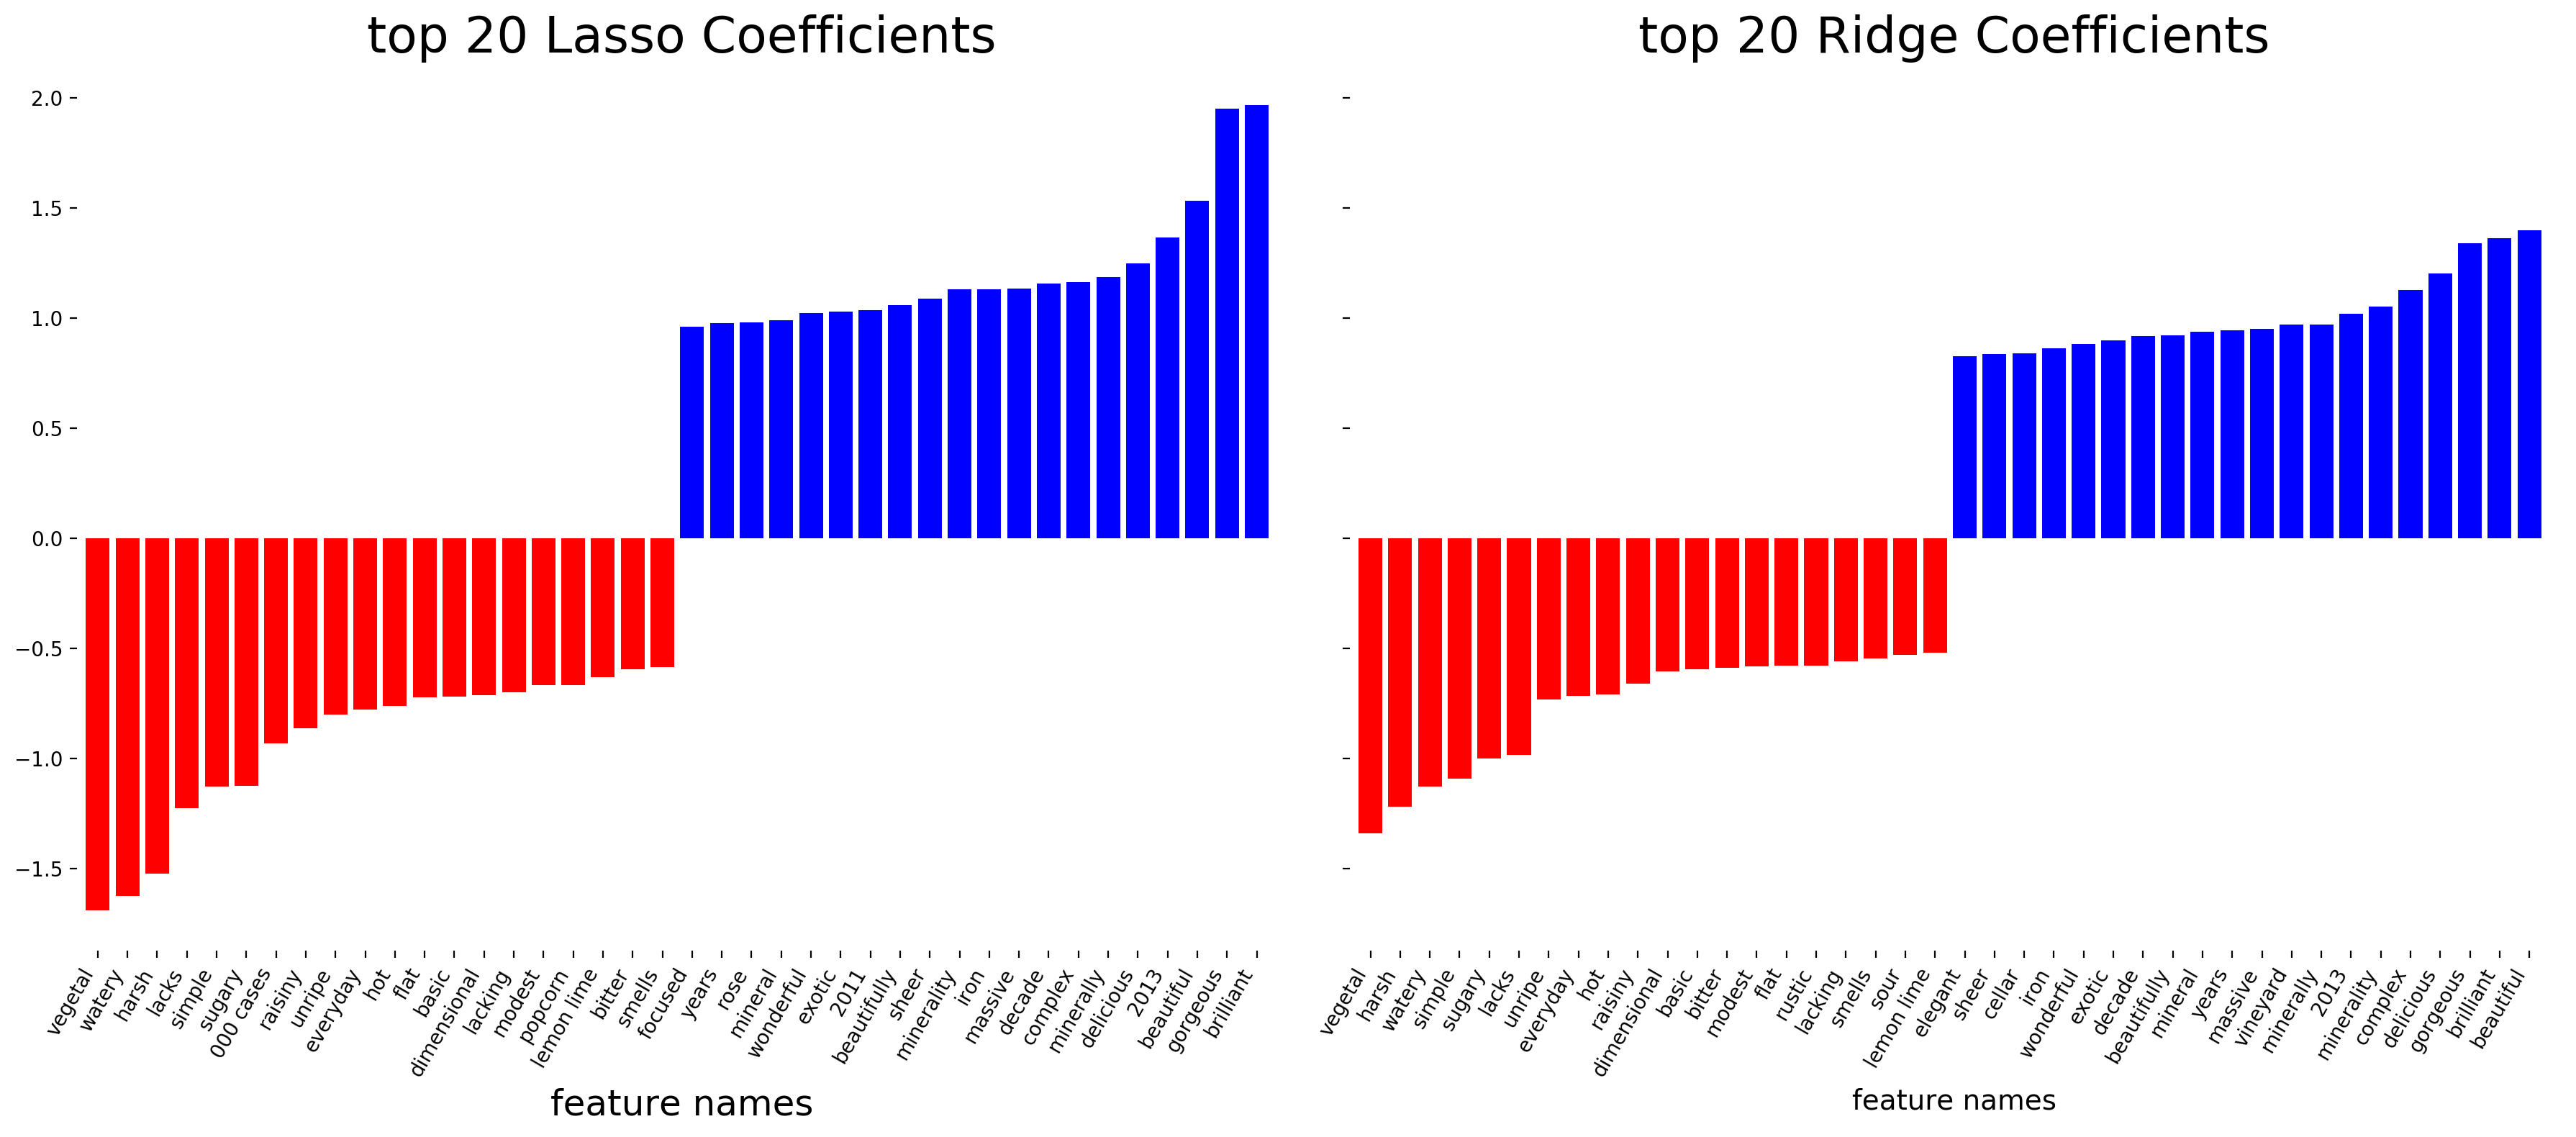

In [98]:
#graph for n-gram range (1,3)
fig7, ax = plt.subplots(1,2, figsize=(18,8), dpi=200, sharey=True)
ax1, ax2 = ax.ravel()

plot_important_features(lasso_grid.best_estimator_.coef_,np.array(trigram_vect.get_feature_names()),ax=ax1)
ax1.set_title('top 20 Lasso Coefficients',fontsize=25)
ax1.set_xlabel('feature names',fontsize=18)


plot_important_features(ridge_grid.best_estimator_.coef_,np.array(trigram_vect.get_feature_names()),ax=ax2)
ax2.set_title('top 20 Ridge Coefficients',fontsize=25)
ax2.set_xlabel('feature names',fontsize=14)

fig7.tight_layout()

It is clear that neither ridge or lasso performed well with only tri-grams, and their score did not improve greatly with the addition of tri-grams rather than bi-grams. We will now try combining Tfid vectorising with n-grams range 1-2

In [40]:
tfid_vect_bigram = TfidfVectorizer(ngram_range=(1,2),
                             token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english',
                             min_df=4,
                             max_features=1000)
desc_tfid_bigram_tokenized = tfid_vect_bigram.fit_transform(X_train['description'])

In [41]:
param_grid = {'alpha': np.logspace(-3,3,10)}
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(desc_tfid_bigram_tokenized, y_train)
print(f'best score: {ridge_grid.best_score_} best param: {ridge_grid.best_params_}')

best score: 0.6740067000474758 best param: {'alpha': 0.46415888336127775}


In [42]:
param_grid = {'alpha': np.logspace(-3,3,10)}
lasso_grid = GridSearchCV(Lasso(), param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(desc_tfid_bigram_tokenized, y_train)
print(f'best score: {lasso_grid.best_score_} best param: {lasso_grid.best_params_}')

best score: 0.6195148872961969 best param: {'alpha': 0.001}


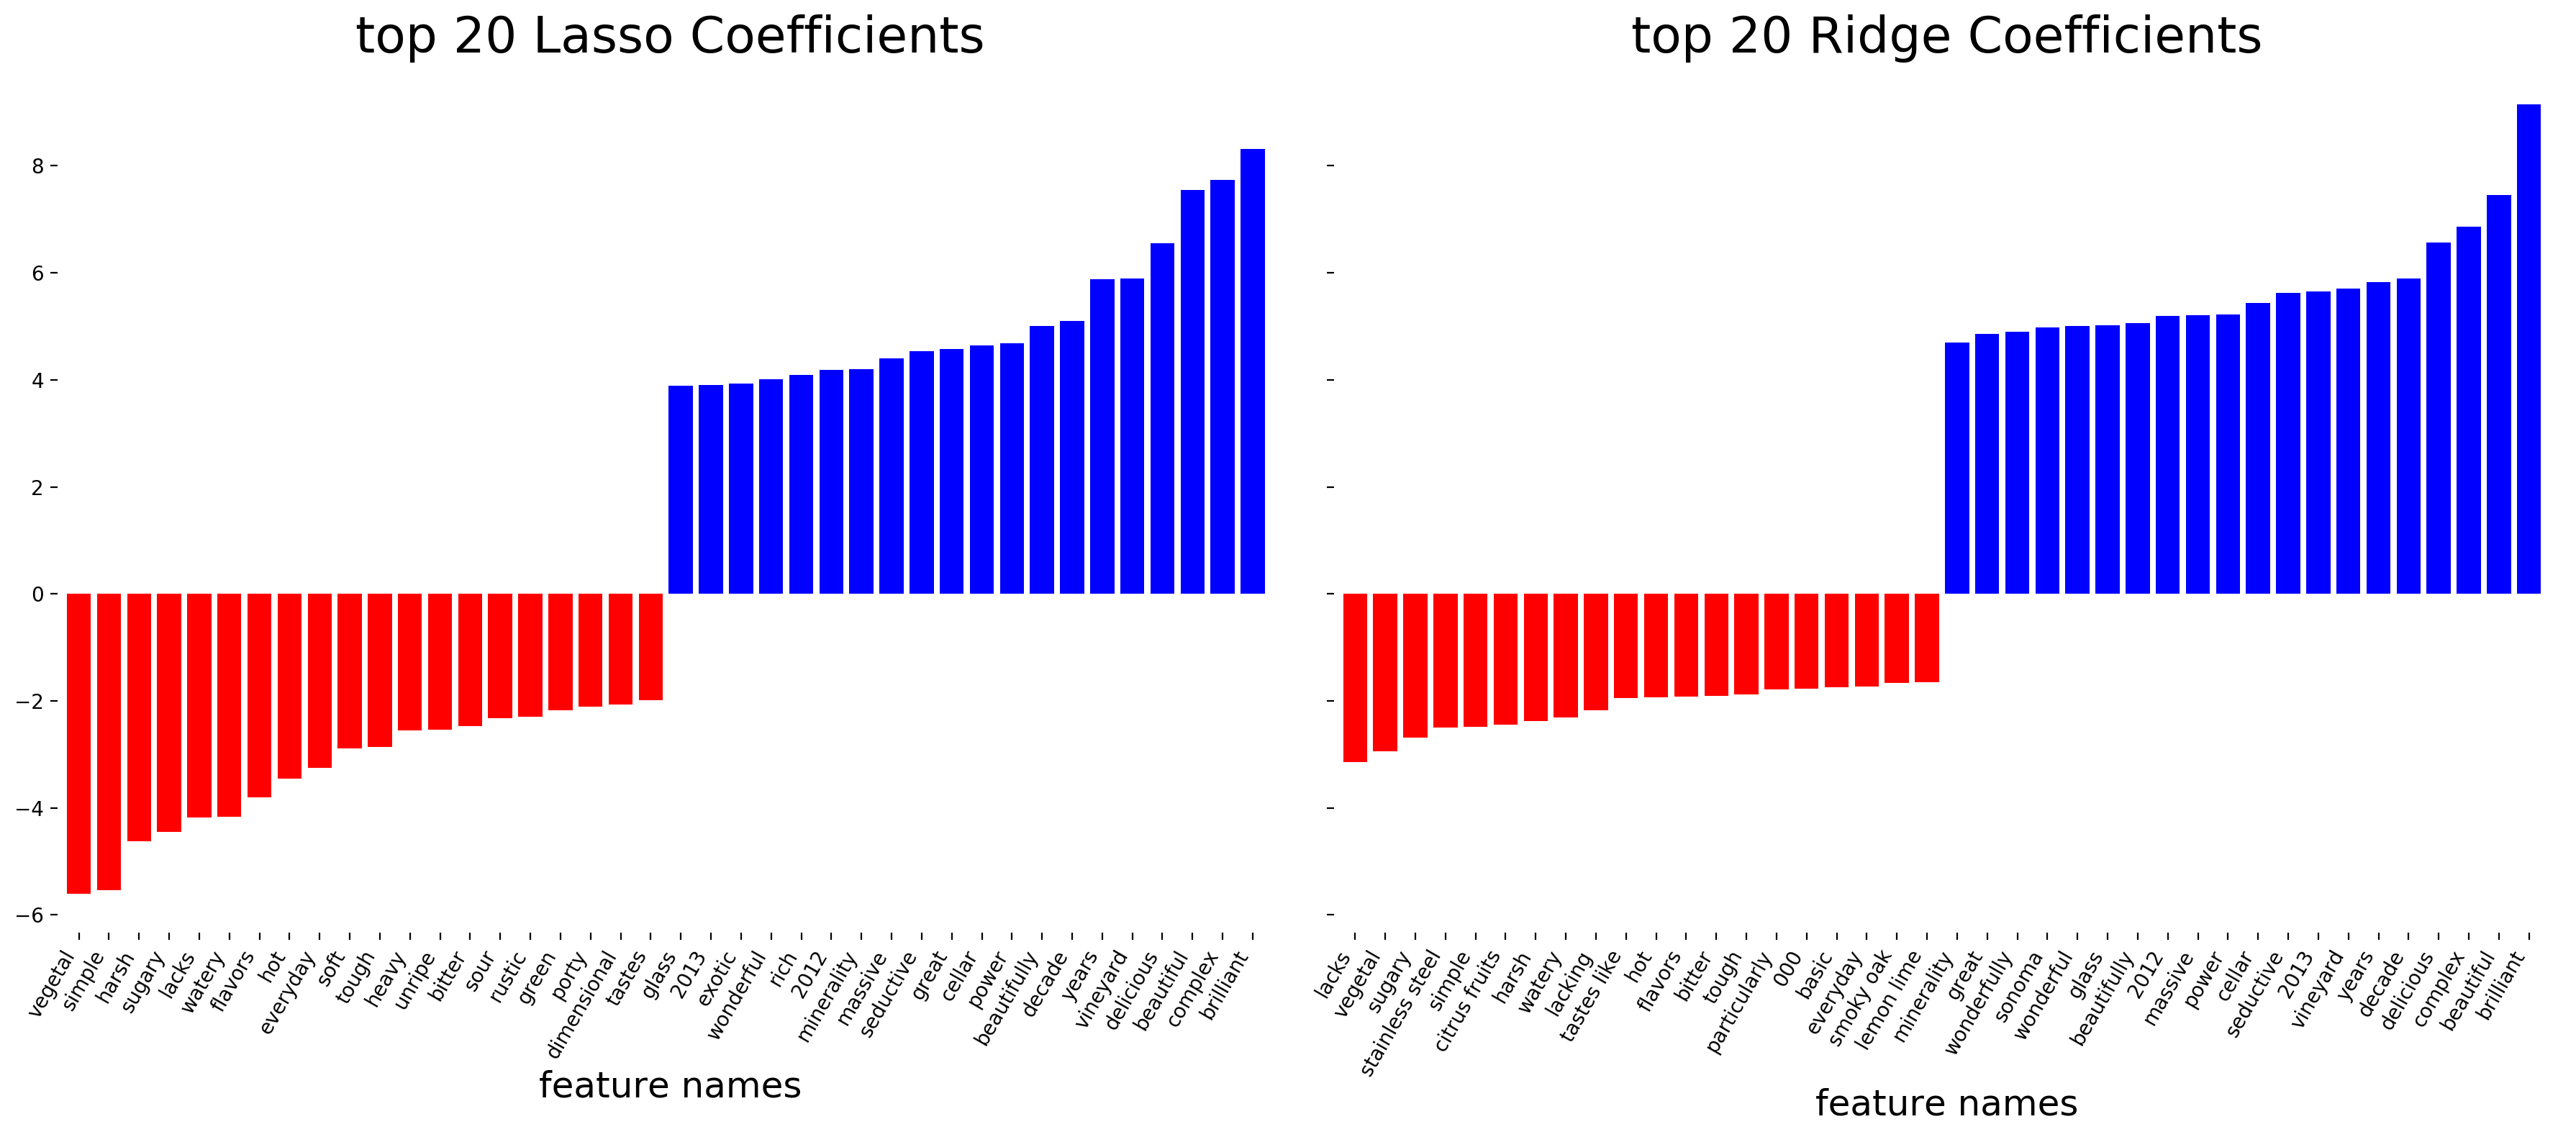

In [45]:
fig8, ax = plt.subplots(1,2, figsize=(18,8), dpi=200, sharey=True)
ax1, ax2 = ax.ravel()

plot_important_features(lasso_grid.best_estimator_.coef_,np.array(tfid_vect_bigram.get_feature_names()),ax=ax1)
ax1.set_title('top 20 Lasso Coefficients',fontsize=25)
ax1.set_xlabel('feature names',fontsize=18)


plot_important_features(ridge_grid.best_estimator_.coef_,np.array(tfid_vect_bigram.get_feature_names()),ax=ax2)
ax2.set_title('top 20 Ridge Coefficients',fontsize=25)
ax2.set_xlabel('feature names',fontsize=18)

fig8.tight_layout()

It is clear that both algorithms had a poor score with trigrams, and performed best with an n-gram range of (1,2) or (1,1)

## Using TFid Vectorizing with character bigrams

In [122]:
def graph_cv_results(lasso_metrics,ridge_metrics):

    #FINAL METRICE BEFORE GRID SEARCH
    cvs_fig, ax = plt.subplots(1, 2, figsize=(15,5),sharex=True, sharey=True)
    ax1, ax3, = ax.ravel()

    ax1.plot(lasso_metrics['train_score'], color='blue')
    ax1.plot(lasso_metrics['test_score'], color='orange')
    ax1.set_title(f'Cross Validation Scores for Lasso', fontsize=20)
    ax1.set_xlabel('fold', fontsize=15)
    ax1.set_ylabel('score out of 1.0', fontsize=15)
    ax1.legend(['train_score','test_score'])
    #sns.boxplot(data = poly_lasso_scores, orient='h',ax=ax2)
    ax3.plot(ridge_metrics['train_score'], color='blue')
    ax3.plot(ridge_metrics['test_score'], color='orange')
    ax3.set_title(f'Cross Validation Scores for Ridge', fontsize=20)
    ax3.set_xlabel('fold', fontsize=15)
    ax3.set_ylabel('score out of 1.0', fontsize=15)
    ax3.legend(['train_score','test_score'])
    #sns.boxplot(data = poly_ridge_scores, orient='h',ax=ax4)
    cvs_fig.tight_layout()

In [116]:
#Lasso's top performing model but using character n-grams
ridge_char_vect=TfidfVectorizer(analyzer="char_wb",
                            ngram_range=(2,5),
                            token_pattern=r"\b\w[\w’]+\b",
                            lowercase=True,
                            stop_words='english',
                            min_df=3,
                            max_features=5000)
lasso_char_vect=CountVectorizer(analyzer="char_wb",
                            ngram_range=(2,5),
                            token_pattern=r"\b\w[\w’]+\b",
                            lowercase=True,
                            stop_words='english',
                            min_df=2,
                            max_features=1000)

In [117]:
ridge_pipe = make_pipeline(ridge_char_vect, Ridge(alpha = 0.46415888336127775))
ridge_metrics = cross_validate(ridge_pipe,X_train['description'], y_train, cv =cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(ridge_metrics["test_score"])} , the standard deviation is {np.std(ridge_metrics["test_score"])})')

The mean score is 0.7280592990653979 , the standard deviation is 0.012066626488353946)


In [120]:
lasso_pipe = make_pipeline(lasso_char_vect, Lasso(alpha=0.001, max_iter=1000))
lasso_metrics = cross_validate(lasso_pipe,X_train['description'], y_train, cv =cv_strategy, return_train_score=True)
print(f'The mean score is {np.mean(lasso_metrics["test_score"])} , the standard deviation is {np.std(lasso_metrics["test_score"])})')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10690.557620994185, tolerance: 14.038688365630172
  max_iter, tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7223.315155910106, tolerance: 13.931031966351206
  max_iter, tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10324.357670441568, tolerance: 14.010576693705872
  max_iter, tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: O

The mean score is 0.6725800313584941 , the standard deviation is 0.009786354106672831)


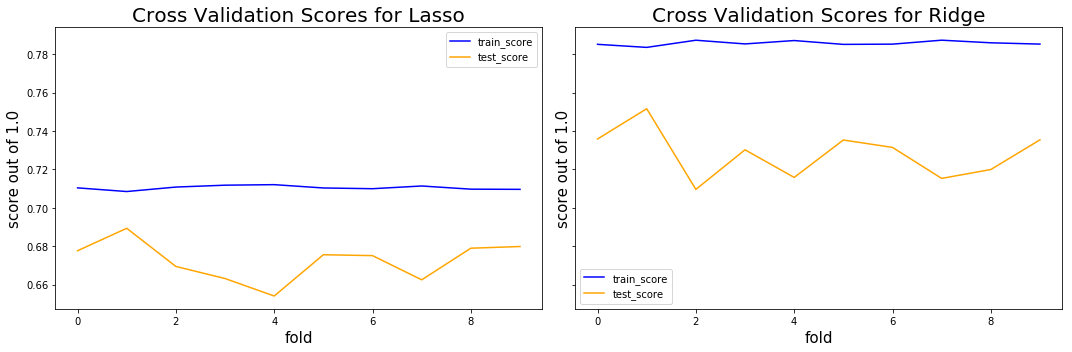

In [123]:
graph_cv_results(lasso_metrics,ridge_metrics)

# 1.3 
#### Combine the non-text features and the text features. How does adding those features improve upon just using bag-of-words?

In [103]:
#category designations
to_target_encode = ['designation', 'winery', 'variety', 'region_1','region_2']
to_ohe = ['province', 'taster_name']
to_scale = ['price']
# pipelines and actions
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
scale = preprocessing.StandardScaler()

In [122]:
lasso_tfid_vect = CountVectorizer(token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')
# lasso_tfid_vect = CountVectorizer(ngram_range=(1,2),
#                              max_features = 1000,
#                              min_df = 2,
#                              token_pattern=r"\b\w[\w’]+\b", 
#                              lowercase=True,
#                              stop_words='english')

ridge_description_tfid_vect = TfidfVectorizer(
                             max_features = 2500,
                             min_df = 4,
                             token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

ridge_title_tfid_vect = TfidfVectorizer(
                             max_features = 5000,
                             min_df = 1,
                             token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')


In [123]:
ridge_total_column_transformer = make_column_transformer(
                                     (ridge_description_tfid_vect, 'description'), 
                                     (ridge_title_tfid_vect, 'title'),
                                     (target_encoding, to_target_encode),
                                     (ohe, to_ohe),
                                     (scale, to_scale),
                                     remainder='passthrough')

lasso_total_column_transformer = make_column_transformer((lasso_tfid_vect, 'description'), 
                                     (lasso_tfid_vect, 'title'),
                                     (target_encoding, to_target_encode),
                                     (ohe, to_ohe),
                                     (scale, to_scale),
                                     remainder='drop')

In [108]:
ridge_total_pipe = make_pipeline(ridge_total_column_transformer, Ridge(alpha=2.154434690031882))
ridge_metrics = cross_validate(ridge_total_pipe,X_train, y_train, cv =cv_strategy, return_train_score=True)

print(np.mean(ridge_metrics["test_score"])) 
print(np.std(ridge_metrics["test_score"]))


0.7042593965500228
0.01418012251514621


In [124]:
lasso_total_pipe = make_pipeline(lasso_total_column_transformer, Lasso(alpha=0.001))
lasso_metrics = cross_validate(lasso_total_pipe,X_train, y_train, cv =cv_strategy, return_train_score=True)

print(np.mean(lasso_metrics["test_score"])) 
print(np.std(lasso_metrics["test_score"]))


0.7114223943216688
0.015473263395014628


In [125]:
lasso_total_pipe.fit(X_train,y_train)
lasso_total_pipe.score(X_test,y_test)

0.7010663059601023

## Below is the combination informatino and scores for the 150k dataset
This is not required for the homework, but it is helpful to see the effect of the particular datset on the hyperparameters and the scores. 

In [161]:
# Encode categorical features 
to_target_encode = ['designation', 'winery', 'variety', 'region_1', 'region_2']
to_ohe = ['province']
to_scale = ['price']
text_data = 'description'
# Create column transformer
target_encoding = make_pipeline(TargetEncoder(), preprocessing.StandardScaler())
#remove the pipeline 
ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
scale = preprocessing.StandardScaler()


ridge_tokenize=TfidfVectorizer(token_pattern=r"\b\w[\w’]+\b", 
                             lowercase=True,
                             stop_words='english')

ridge_preprocessing_pipe = make_column_transformer((ridge_tokenize,text_data),
                                            (target_encoding, to_target_encode),
                                            (ohe, to_ohe),
                                            (scale, to_scale),
                                            remainder='passthrough')


In [159]:
param_grid_ridge = {
    'columntransformer__tfidfvectorizer__min_df': (0, 1, 2, 3, 4),
    'columntransformer__tfidfvectorizer__max_features': (1000, 2500, 5000),
    'ridge__alpha': np.logspace(-3, 3, 10),
    'columntransformer__tfidfvectorizer__ngram_range': ((1,2),(2,2),(1,3),(3,3),(2,3))
}
param_grid_lasso = {
    'columntransformer__countvectorizer__min_df': (0, 1, 2, 3, 4),
    'columntransformer__countvectorizer__max_features': (1000, 2500, 5000),
    'lasso__alpha': np.logspace(-3, 3, 10),
    'columntransformer__countvectorizer__ngram_range': ((1,2),(2,2),(1,3),(3,3),(2,3))
}

In [153]:
ridge_pipe = make_pipeline(ridge_preprocessing_pipe, Ridge())
ridge_grid = GridSearchCV(ridge_pipe, param_grid_ridge, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train, y_train)
print(f'best score: {ridge_grid.best_score_} best params: {ridge_grid.best_params_}')

best score: 0.7775989511828699 best params: {'columntransformer__tfidfvectorizer__max_features': 5000, 'columntransformer__tfidfvectorizer__min_df': 2, 'columntransformer__tfidfvectorizer__ngram_range': (1, 2), 'ridge__alpha': 0.46415888336127775}


In [162]:
lasso_tokenize=CountVectorizer(token_pattern=r"\b\w[\w’]+\b",
                             max_features = 1000,
                             min_df = 2,
                             ngram_range = (1,2),
                             lowercase=True,
                             stop_words='english')
lasso_preprocessing_pipe = make_column_transformer((lasso_tokenize,text_data),
                                            (target_encoding, to_target_encode),
                                            (ohe, to_ohe),
                                            (scale, to_scale),
                                            remainder='passthrough')

In [164]:
lasso_pipe = make_pipeline(lasso_preprocessing_pipe, Lasso(alpha=0.001))
lasso_metrics = cross_validate(lasso_pipe,X_train, y_train, cv =cv_strategy, return_train_score=True)

print(np.mean(lasso_metrics["test_score"])) 
print(np.std(lasso_metrics["test_score"]))


0.7395399638968049
0.006071322620352659


In [170]:
lasso_tokenize=CountVectorizer()
lasso_preprocessing_pipe = make_column_transformer((lasso_tokenize,text_data),
                                            (target_encoding, to_target_encode),
                                            (ohe, to_ohe),
                                            (scale, to_scale),
                                            remainder='passthrough')

In [171]:
lasso_pipe = make_pipeline(lasso_preprocessing_pipe, Lasso(alpha=0.001))
lasso_metrics = cross_validate(lasso_pipe,X_train, y_train, cv =cv_strategy, return_train_score=True)

print(np.mean(lasso_metrics["test_score"])) 
print(np.std(lasso_metrics["test_score"]))

0.771991164973359
0.005766530426446681


# Final thoughts on question 1

The performance of combining the text data and non-text data was much higher than any one of them alone. Lasso with CountVectorizer() and tuned hyperparameters was the top performer overall. n-grams of (1,1) and (1,2) was the most efective on text data while (3,3) was the worst score of all. Finally, the character n-grams were not helpful for our use, however they could potentially be helpful if we were to include twitter handle information! 